### Visualize W&B results

In [1]:
import pandas as pd
import os
import numpy as np
import json
import matplotlib.pyplot as plt
plt.ioff()  # <- Turn off interactive mode

import matplotlib.gridspec as gridspec

import visualize_functions as vf

import wandb
wandb.login()

wandb: Currently logged in as: simonkral99 (uni-ma) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
api = wandb.Api()

# Replace with your actual W&B username and project name
runs = api.runs("simonkral99/Thesis_MTSF")

In [ ]:
update_runs = True

if update_runs:
    run_data = []
    for run in runs:
        summary = run.summary._json_dict
        config = {k: v for k, v in run.config.items() if not k.startswith('_')}
        run_data.append({**config, **summary, "run_id": run.id, "name": run.name})
    df = pd.DataFrame(run_data)

    columns_to_keep = ['model', 'pred_len', 'random_seed', 'patience', 'data_path', 'mae', 'mse', 'seq_len', 'conv_kernel_size', 'n_blocks', 'cd_regularization', 'learn_cd_regularization', 
                   'convex', 'sigmoid', 'lambda_freeze_patience', "cd_weight_decay", "mse_train", "mae_train", "mse_train_per_channel_list", "mse_per_channel_list"
                   , "mae_train_per_channel_list", "mae_per_channel_list", "channel_handling", "learning_rate", "batch_size", "head_dropout", "dropout", "delta_factor", "setting_string",
                   "skip_1st_epoch"]
    
    df = df[columns_to_keep].copy()
    df['data_path'] = df['data_path'].str.replace('.csv', '', regex=False)

    # Save the DataFrame to a CSV file
    #df.to_csv("wandb_runs.csv", index=False)
    df.to_pickle("wandb_runs.pkl")
else:
    # Load the DataFrame from the CSV file
    #df = pd.read_csv("wandb_runs.csv")
    df = pd.read_pickle("wandb_runs.pkl")

#print(df.columns)

In [5]:
df['delta_factor'] = df['delta_factor'].fillna(1)
df['skip_1st_epoch'] = df['skip_1st_epoch'].fillna(0)
df_subset = df.copy()

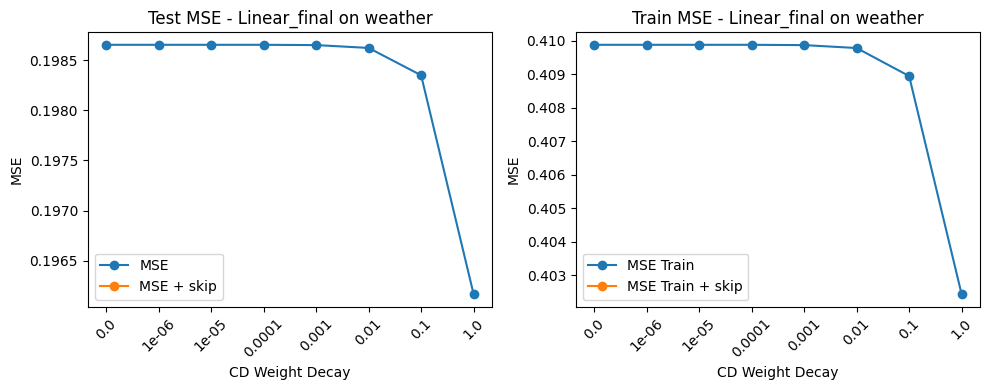

In [37]:
import matplotlib.pyplot as plt


# Shared filter params
data = "weather"
channel_handling = "CD"
model = "Linear_final"
random_seed = 2021
pred_len = 96
#pred_len = 24
patience = 20
seq_len = 336
#seq_len = 104

fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

for i, (skip, label_suffix) in enumerate([(0, ""), (1, " + skip")]):
    df_filtered = df_subset[
        (df_subset['data_path'].str.contains(data)) &
        (~df_subset['data_path'].str.contains("lag")) &
        (df_subset['model'] == model) &
        (df_subset['channel_handling'] == channel_handling) &
        (df_subset['random_seed'] == random_seed) &
        (df_subset['skip_1st_epoch'] == skip) &
        (df_subset['pred_len'] == pred_len) &
        (df_subset['patience'] == patience) &
        (df_subset['seq_len'] == seq_len)
    ].sort_values(by='cd_weight_decay')

    # Plot on both subplots
    axes[0].plot(df_filtered['cd_weight_decay'].astype(str), df_filtered['mse'], marker='o', label='MSE' + label_suffix)
    axes[1].plot(df_filtered['cd_weight_decay'].astype(str), df_filtered['mse_train'], marker='o', label='MSE Train' + label_suffix)

# Customize left plot (Test)
axes[0].set_title(f'Test MSE - {model} on {data}')
axes[0].set_xlabel('CD Weight Decay')
axes[0].set_ylabel('MSE')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# Customize right plot (Train)
axes[1].set_title(f'Train MSE - {model} on {data}')
axes[1].set_xlabel('CD Weight Decay')
axes[1].set_ylabel('MSE')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### Results published in papers

In [5]:
paper_results_df = pd.read_csv('../paper_results.csv')
paper_results_df.head()

,Dataset,Prediction Length,MSE,MAE,model,source,ci_cd,model_source
0,ETTm1,96,0.288,0.343,TVNet,li2025_tvnet,CD,TVNet (li2025_tvnet)
1,ETTm1,192,0.326,0.367,TVNet,li2025_tvnet,CD,TVNet (li2025_tvnet)
2,ETTm1,336,0.365,0.391,TVNet,li2025_tvnet,CD,TVNet (li2025_tvnet)
3,ETTm1,720,0.412,0.413,TVNet,li2025_tvnet,CD,TVNet (li2025_tvnet)
4,ETTm1,Avg,0.348,0.379,TVNet,li2025_tvnet,CD,TVNet (li2025_tvnet)


In [6]:

"""
df_ref = paper_results_df[
    (paper_results_df['source'] == "nie2023_patchtst") #| 
    #(paper_results_df['model'] == "Linear") | (paper_results_df['model'] == "Linear_CI") | (paper_results_df['model'] == "Linear_CD")
    #(paper_results_df['model'] == "Linear_CI") | (paper_results_df['model'] == "Linear_CD")
]
"""
df_ref = paper_results_df.copy()

df_ref.columns = ['data_path', 'pred_len', 'mse', 'mae', 'model', 'source', 'ci_cd', 'model_source']
df_ref = df_ref.replace("ILI", "national_illness")
df_ref = df_ref.replace("Traffic", "traffic")
df_ref = df_ref.replace("Weather", "weather")
df_ref = df_ref.replace("Electricity", "electricity")
df_ref = df_ref.replace("Exchange", "exchange_rate")

df_ref = df_ref.dropna()

color_map = {'CI': 'tab:blue', 'CD': 'tab:orange'}

display(df_ref.head())

,data_path,pred_len,mse,mae,model,source,ci_cd,model_source
0,ETTm1,96,0.288,0.343,TVNet,li2025_tvnet,CD,TVNet (li2025_tvnet)
1,ETTm1,192,0.326,0.367,TVNet,li2025_tvnet,CD,TVNet (li2025_tvnet)
2,ETTm1,336,0.365,0.391,TVNet,li2025_tvnet,CD,TVNet (li2025_tvnet)
3,ETTm1,720,0.412,0.413,TVNet,li2025_tvnet,CD,TVNet (li2025_tvnet)
4,ETTm1,Avg,0.348,0.379,TVNet,li2025_tvnet,CD,TVNet (li2025_tvnet)


# Compare results (han2024_capacity)

In [7]:
model = "Linear_Delta_reg"
metric = "mse"
hyperparam = "cd_weight_decay"

df_delta = df_subset[(df_subset['model'] == model)]
df_delta = df_delta.sort_values(by=hyperparam, ascending=True)

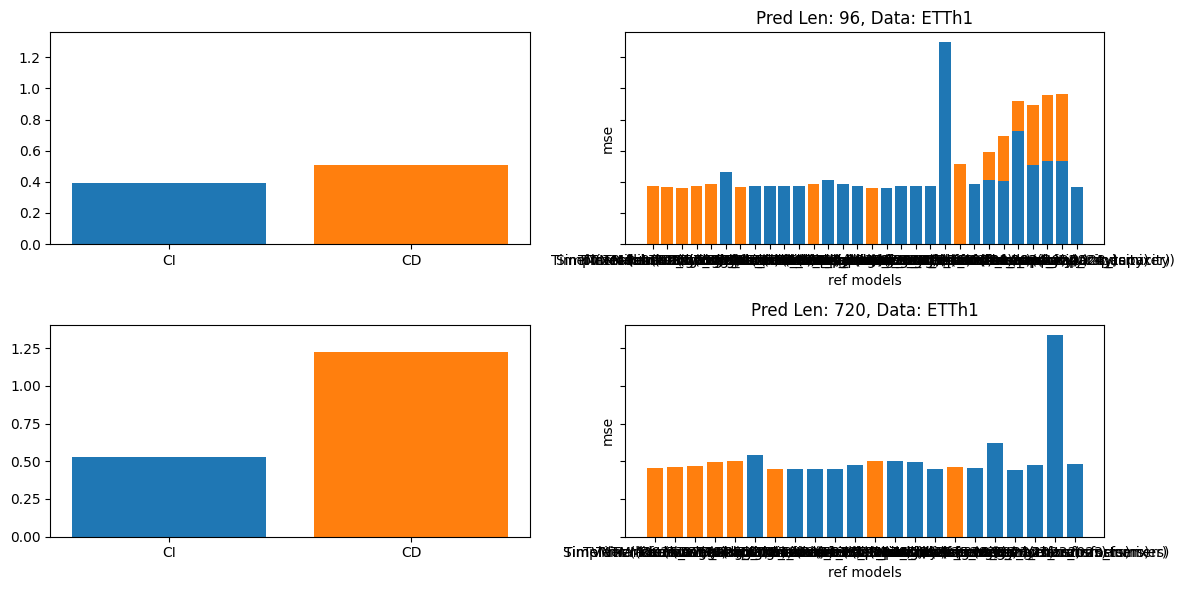

In [8]:
pred_len_list = [96, 720]
data_path_list = ["ETTh1"]

fig, axs = plt.subplots(len(pred_len_list)*len(data_path_list), 2, figsize=(12, 6), sharey='row')

#df_ref = df_ref[(df_ref['data_path'] == "ETTh1")]

for i, pred_len in enumerate(pred_len_list):
    for j, data_path in enumerate(data_path_list):
        #df_CI = df_subset[(df_subset['model'] == "Linear") & (df_subset['data_path'] == data_path) & (df_subset['pred_len'] == pred_len)]
        df_CI = df_subset[(df_subset['model'] == "Linear") & (df_subset['data_path'] == data_path) & (df_subset['pred_len'] == pred_len) & (df_subset['seq_len'] == 96)]
        axs[i * len(data_path_list) + j, 0].bar("CI", df_CI[metric])

        #df_CD = df_subset[(df_subset['model'] == "Linear_CD") & (df_subset['data_path'] == data_path) & (df_subset['pred_len'] == pred_len)]
        df_CD = df_subset[(df_subset['model'] == "Linear_CD") & (df_subset['data_path'] == data_path) & (df_subset['pred_len'] == pred_len) & (df_subset['seq_len'] == 96)]
        axs[i * len(data_path_list) + j, 0].bar("CD", df_CD[metric])

        df_filtered = df_ref[(df_ref['pred_len'] == str(pred_len)) & (df_ref['data_path'] == data_path)]    # str(pred_len) to match the type in df_ref, "Avg"...
        categories = df_filtered["ci_cd"].tolist()
        colors = [color_map[cat] for cat in categories]
        axs[i * len(data_path_list) + j, 1].bar(df_filtered["model_source"], df_filtered[metric], color=colors)
        axs[i * len(data_path_list) + j, 1].set_title(f'Pred Len: {pred_len}, Data: {data_path}')
        axs[i * len(data_path_list) + j, 1].set_ylabel(metric)
        axs[i * len(data_path_list) + j, 1].set_xlabel("ref models")

plt.tight_layout()
plt.savefig("plots/Comp/"+data_path+"_Linear_Delta.png")
plt.show()

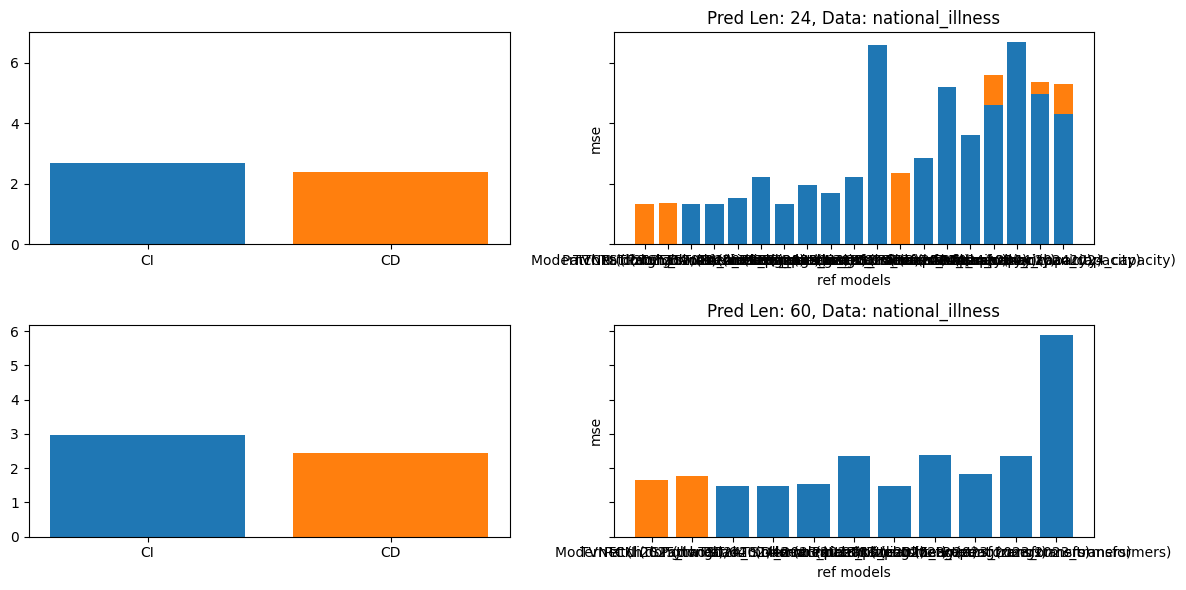

In [9]:
pred_len_list = [24, 60]
data_path_list = ["national_illness"]

fig, axs = plt.subplots(len(pred_len_list)*len(data_path_list), 2, figsize=(12, 6), sharey='row')

#df_ref = df_ref[(df_ref['data_path'] == "ETTh1")]

for i, pred_len in enumerate(pred_len_list):
    for j, data_path in enumerate(data_path_list):
        #df_CI = df_subset[(df_subset['model'] == "Linear") & (df_subset['data_path'] == data_path) & (df_subset['pred_len'] == pred_len)]
        df_CI = df_subset[(df_subset['model'] == "Linear") & (df_subset['data_path'] == data_path) & (df_subset['pred_len'] == pred_len) & (df_subset['seq_len'] == 36)]
        axs[i * len(data_path_list) + j, 0].bar("CI", df_CI[metric])

        #df_CD = df_subset[(df_subset['model'] == "Linear_CD") & (df_subset['data_path'] == data_path) & (df_subset['pred_len'] == pred_len)]
        df_CD = df_subset[(df_subset['model'] == "Linear_CD") & (df_subset['data_path'] == data_path) & (df_subset['pred_len'] == pred_len) & (df_subset['seq_len'] == 36)]
        axs[i * len(data_path_list) + j, 0].bar("CD", df_CD[metric])

        df_filtered = df_ref[(df_ref['pred_len'] == str(pred_len)) & (df_ref['data_path'] == data_path)]    # str(pred_len) to match the type in df_ref, "Avg"...
        categories = df_filtered["ci_cd"].tolist()
        colors = [color_map[cat] for cat in categories]
        axs[i * len(data_path_list) + j, 1].bar(df_filtered["model_source"], df_filtered[metric], color=colors)
        axs[i * len(data_path_list) + j, 1].set_title(f'Pred Len: {pred_len}, Data: {data_path}')
        axs[i * len(data_path_list) + j, 1].set_ylabel(metric)
        axs[i * len(data_path_list) + j, 1].set_xlabel("ref models")

plt.tight_layout()
plt.savefig("plots/Comp/"+data_path+"_"+model+".png")
plt.show()

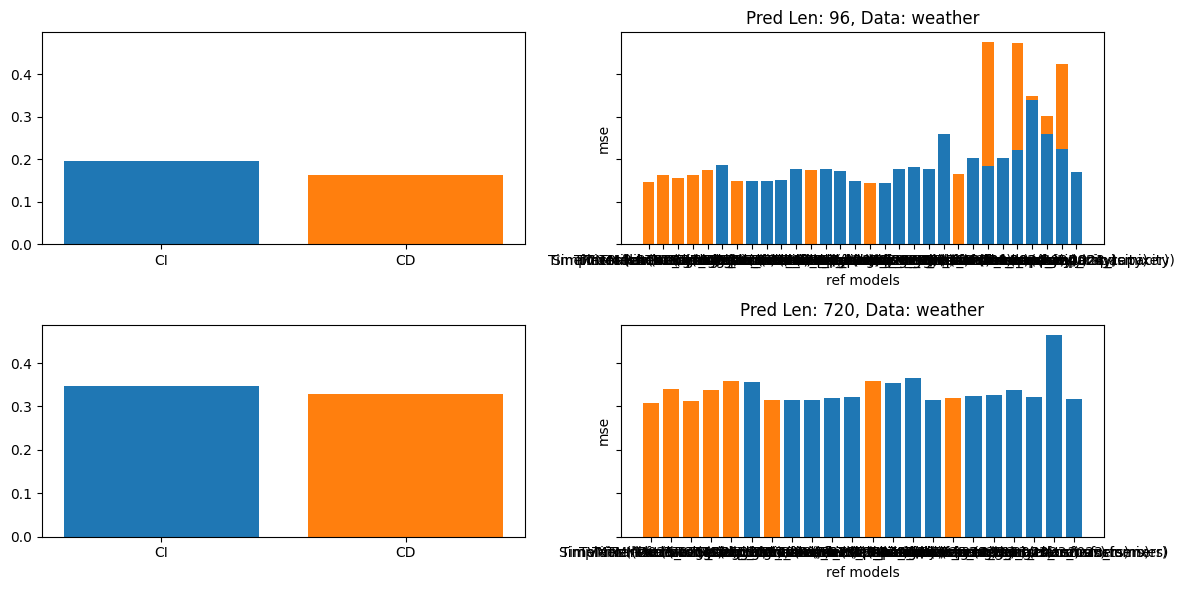

In [10]:
pred_len_list = [96, 720]
data_path_list = ["weather"]

fig, axs = plt.subplots(len(pred_len_list)*len(data_path_list), 2, figsize=(12, 6), sharey='row')

#df_ref = df_ref[(df_ref['data_path'] == "ETTh1")]

for i, pred_len in enumerate(pred_len_list):
    for j, data_path in enumerate(data_path_list):
        #df_CI = df_subset[(df_subset['model'] == "Linear") & (df_subset['data_path'] == data_path) & (df_subset['pred_len'] == pred_len)]
        df_CI = df_subset[(df_subset['model'] == "Linear") & (df_subset['data_path'] == data_path) & (df_subset['pred_len'] == pred_len) & (df_subset['seq_len'] == 96)]
        axs[i * len(data_path_list) + j, 0].bar("CI", df_CI[metric])

        #df_CD = df_subset[(df_subset['model'] == "Linear_CD") & (df_subset['data_path'] == data_path) & (df_subset['pred_len'] == pred_len)]
        df_CD = df_subset[(df_subset['model'] == "Linear_CD") & (df_subset['data_path'] == data_path) & (df_subset['pred_len'] == pred_len) & (df_subset['seq_len'] == 96)]
        axs[i * len(data_path_list) + j, 0].bar("CD", df_CD[metric])

        df_filtered = df_ref[(df_ref['pred_len'] == str(pred_len)) & (df_ref['data_path'] == data_path)]    # str(pred_len) to match the type in df_ref, "Avg"...
        categories = df_filtered["ci_cd"].tolist()
        colors = [color_map[cat] for cat in categories]
        axs[i * len(data_path_list) + j, 1].bar(df_filtered["model_source"], df_filtered[metric], color=colors)
        axs[i * len(data_path_list) + j, 1].set_title(f'Pred Len: {pred_len}, Data: {data_path}')
        axs[i * len(data_path_list) + j, 1].set_ylabel(metric)
        axs[i * len(data_path_list) + j, 1].set_xlabel("ref models")

plt.tight_layout()
plt.savefig("plots/Comp/"+data_path+"_"+model+".png")
plt.show()

# NEW Shower example (dataset selection)
#### 1 Channel of exisiting dataset + lagged one

## Check Avg error channel-wise = error

In [11]:
import statistics

"""
pred_len_list = [96, 720]
data_path_list = ["ETTh1", "weather"]

decimals = 5

for i, pred_len in enumerate(pred_len_list):
    for j, data_path in enumerate(data_path_list):
        df_CI = df_subset[(df_subset['data_path'].str.contains(data_path)) & (df_subset['pred_len'] == pred_len) & (df_subset["mse_train_per_channel_list"].notna())].copy()
        
        for index, row in df_CI.iterrows():
            print(index, data_path, round(statistics.mean(row['mse_per_channel_list']), decimals), round(statistics.mean(row['mse_train_per_channel_list']), decimals))
            print(index, data_path, round(row['mse'], decimals), round(row['mse_train'], decimals))
            print()
            print(index, data_path, round(statistics.mean(row['mae_per_channel_list']), decimals), round(statistics.mean(row['mae_train_per_channel_list']), decimals))
            print(index, data_path, round(row['mae'], decimals), round(row['mae_train'], decimals))
            print()
            
"""

'\npred_len_list = [96, 720]\ndata_path_list = ["ETTh1", "weather"]\n\ndecimals = 5\n\nfor i, pred_len in enumerate(pred_len_list):\n    for j, data_path in enumerate(data_path_list):\n        df_CI = df_subset[(df_subset[\'data_path\'].str.contains(data_path)) & (df_subset[\'pred_len\'] == pred_len) & (df_subset["mse_train_per_channel_list"].notna())].copy()\n        \n        for index, row in df_CI.iterrows():\n            print(index, data_path, round(statistics.mean(row[\'mse_per_channel_list\']), decimals), round(statistics.mean(row[\'mse_train_per_channel_list\']), decimals))\n            print(index, data_path, round(row[\'mse\'], decimals), round(row[\'mse_train\'], decimals))\n            print()\n            print(index, data_path, round(statistics.mean(row[\'mae_per_channel_list\']), decimals), round(statistics.mean(row[\'mae_train_per_channel_list\']), decimals))\n            print(index, data_path, round(row[\'mae\'], decimals), round(row[\'mae_train\'], decimals))\n     

# Remove duplicates

In [12]:
columns_to_keep = ['model', 'pred_len', 'random_seed', 'data_path', 'mae', 'mse', 'seq_len', "cd_weight_decay", "mse_train", "mae_train", "mse_train_per_channel_list", 
                   "mse_per_channel_list", "mae_train_per_channel_list", "mae_per_channel_list", "channel_handling", "learning_rate", "batch_size", "patience", "head_dropout",
                   "dropout", "delta_factor"]

# Keep only those columns
df_subset = df[columns_to_keep]
df_subset['data_path'] = df_subset['data_path'].str.replace('.csv', '', regex=False)

df_subset = df_subset[df_subset['model'].isin(["Linear_final", "ModernTCN", "PatchTST"])]

df_hashable = df_subset.loc[:, df_subset.applymap(type).ne(list).all()]
duplicates = df_hashable[df_hashable.duplicated()]
display(duplicates)

# Remove duplicates from df_subset based on hashable columns
df_subset = df_subset[~df_hashable.duplicated()]

/scratch/ipykernel_383591/3805830119.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['data_path'] = df_subset['data_path'].str.replace('.csv', '', regex=False)
/scratch/ipykernel_383591/3805830119.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_hashable = df_subset.loc[:, df_subset.applymap(type).ne(list).all()]


,model,pred_len,random_seed,data_path,mae,mse,seq_len,cd_weight_decay,mse_train,mae_train,channel_handling,learning_rate,batch_size,patience,head_dropout,dropout,delta_factor
473,PatchTST,96,2021,ETTm2,0.254921,0.164901,336,0.000000,0.208256,0.258387,CI_glob,0.0001,128,20,0.0,0.20,1.0
479,PatchTST,96,2021,ETTm2,0.254921,0.164901,336,0.000000,0.208256,0.258387,CI_glob,0.0001,128,20,0.0,0.20,1.0
542,PatchTST,96,2021,ETTm2,0.251381,0.163358,336,0.000000,0.191638,0.250169,CI_loc,0.0001,128,20,0.0,0.20,1.0
563,PatchTST,96,2021,ETTm2,0.254921,0.164901,336,0.000000,0.208256,0.258387,CI_glob,0.0001,128,20,0.0,0.20,1.0
592,PatchTST,96,2021,weather,0.199393,0.151571,336,0.000000,0.405948,0.293351,CI_glob,0.0001,128,20,0.0,0.20,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4447,Linear_final,720,2021,ETTh2,1.839908,5.323550,336,0.100000,0.469051,0.454110,Delta,0.0050,32,20,0.0,0.05,1.0
4466,Linear_final,336,2024,ETTm1,0.498684,0.502525,336,0.100000,0.331786,0.410272,Delta,0.0050,32,20,0.0,0.05,1.0
4469,Linear_final,720,2024,ETTm1,0.624558,0.747674,336,0.100000,0.388284,0.447019,Delta,0.0050,32,20,0.0,0.05,1.0
4472,Linear_final,96,2025,ETTm1,0.418240,0.375989,336,0.000001,0.248499,0.349965,CD,0.0050,32,20,0.0,0.05,1.0


# Remove unwanted HPs

In [13]:
# Make a copy of the index to avoid modifying during iteration
rows_to_drop = []

for idx, row in df_subset.iterrows():
    if row["model"] == "Linear_final":
        if row["learning_rate"] != 0.005:
            rows_to_drop.append(idx)
            #print(row.to_string())
        elif row["data_path"] in ["traffic", "electricity"] and (row["batch_size"] != 16 or row["patience"] != 10):
            rows_to_drop.append(idx)
        elif row["data_path"] in ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "weather", "exchange_rate", "national_illness"] and (row["batch_size"] != 32 or row["patience"] != 20):
            rows_to_drop.append(idx)

    elif row["model"] == "PatchTST":
        if row["data_path"] in ["traffic", "electricity"] and row["patience"] != 10:
            rows_to_drop.append(idx)
            print(row.to_string())
        elif row["data_path"] in ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "national_illness", "weather"] and row["patience"] != 20:
            rows_to_drop.append(idx)
            print(row.to_string())
    
    elif row["model"] == "ModernTCN":
        if row["channel_handling"] == "Delta" and row["delta_factor"] != 0.5:
            rows_to_drop.append(idx)
        elif row["data_path"] in ["ETTh1", "ETTh2"] and (row["patience"] != 20 or row["batch_size"] != 512 or row["head_dropout"] != 0 or row["dropout"] != 0.3):
            rows_to_drop.append(idx)
            #print(row.to_string())
        #elif row["data_path"] in ["ETTm1", "ETTm2"] and (row["patience"] != 20 or row["batch_size"] != 512 or row["head_dropout"] != 0.1 or row["dropout"] != 0.3):
        elif row["data_path"] in ["ETTm1", "ETTm2"] and (row["patience"] != 20 or row["batch_size"] != 512 or row["head_dropout"] != 0.0 or row["dropout"] != 0.3):
            rows_to_drop.append(idx)
            print(row.to_string())
        elif row["data_path"] in ["electricity"] and (row["patience"] != 10 or row["batch_size"] != 512 or row["head_dropout"] != 0 or row["dropout"] != 0.9):
            rows_to_drop.append(idx)
        elif row["data_path"] in ["traffic"] and (row["patience"] != 10 or row["batch_size"] != 32 or row["head_dropout"] != 0 or row["dropout"] != 0.9):
            rows_to_drop.append(idx)
        elif row["data_path"] in ["national_illness"] and (row["patience"] != 5 or row["batch_size"] != 32 or row["head_dropout"] != 0 or row["dropout"] != 0.1):
            rows_to_drop.append(idx)
        elif row["data_path"] in ["weather"] and (row["patience"] != 20 or row["batch_size"] != 512 or row["head_dropout"] != 0 or row["dropout"] != 0.4):
            rows_to_drop.append(idx)
        elif row["data_path"] in ["exchange_rate"] and (row["patience"] != 20 or row["batch_size"] != 512 or row["head_dropout"] != 0.6 or row["dropout"] != 0.2):
            rows_to_drop.append(idx)


print(f"Dropping {len(rows_to_drop)} rows based on model and hyperparameter conditions.")

dropped_rows_df = df_subset.loc[rows_to_drop]
display(dropped_rows_df[dropped_rows_df["model"] == "Linear_final"])

# Drop the rows head_dropout
df_subset = df_subset.drop(index=rows_to_drop)

#display(df)
display(df[(df["model"] == "Linear_final") & (df["data_path"] == "ETTh1")& (df["patience"] == 20)& (df["random_seed"] == 2021)])


model                                                                 ModernTCN
pred_len                                                                     96
random_seed                                                                2021
data_path                                                                 ETTm2
mae                                                                    0.257687
mse                                                                    0.169133
seq_len                                                                     336
cd_weight_decay                                                             0.0
mse_train                                                               0.19823
mae_train                                                              0.257306
mse_train_per_channel_list    [0.30523407459259033, 0.3695241808891296, 0.07...
mse_per_channel_list          [0.27678433060646057, 0.20330683887004852, 0.0...
mae_train_per_channel_list    [0.3430073

,model,pred_len,random_seed,data_path,mae,mse,seq_len,cd_weight_decay,mse_train,mae_train,...,mse_per_channel_list,mae_train_per_channel_list,mae_per_channel_list,channel_handling,learning_rate,batch_size,patience,head_dropout,dropout,delta_factor
372,Linear_final,24,2021,national_illness,1.007183,2.102564,104,0.00,0.394944,0.366163,...,"[1.2795681953430176, 1.4879956245422363, 2.669...","[0.44661766290664673, 0.4632702171802521, 0.36...","[0.8365415930747986, 0.8709419369697571, 1.221...",CI_loc,0.010,32,10,0.0,0.05,1.0
373,Linear_final,60,2021,national_illness,1.061013,2.337934,104,0.00,0.437178,0.387012,...,"[1.1322600841522217, 1.4373668432235718, 3.035...","[0.4679250121116638, 0.4844402074813843, 0.374...","[0.7516383528709412, 0.8406380414962769, 1.286...",CI_loc,0.010,32,10,0.0,0.05,1.0
374,Linear_final,24,2021,national_illness,1.015963,2.059126,104,0.00,0.433773,0.389284,...,"[0.7935888171195984, 1.051599621772766, 2.8165...","[0.4797400236129761, 0.4878038763999939, 0.351...","[0.5763511657714844, 0.656266450881958, 1.1893...",CI_glob,0.010,32,10,0.0,0.05,1.0
375,Linear_final,60,2021,national_illness,1.085548,2.322095,104,0.00,0.482324,0.413746,...,"[0.6940938234329224, 0.9500561952590942, 3.304...","[0.49941712617874146, 0.5082030892372131, 0.37...","[0.5432988405227661, 0.6210782527923584, 1.296...",CI_glob,0.010,32,10,0.0,0.05,1.0
376,Linear_final,24,2021,national_illness,1.142466,2.627512,104,0.00,0.640319,0.522808,...,"[1.6276333332061768, 1.8253828287124632, 3.025...","[0.542434573173523, 0.5593680739402771, 0.5139...","[0.9784443974494934, 1.016486406326294, 1.3090...",CD,0.010,32,10,0.0,0.05,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4923,Linear_final,336,2021,ETTh1,0.925452,1.378903,336,0.01,0.375291,0.453402,...,"[1.345872163772583, 1.991022706031799, 1.08969...","[0.4539487957954407, 0.41330912709236145, 0.42...","[0.9201767444610596, 1.248993158340454, 0.7827...",CD,0.005,32,100,0.0,0.05,1.0
4927,Linear_final,96,2021,ETTh1,0.701156,0.873416,336,0.10,0.322052,0.414229,...,"[1.2077454328536987, 0.8245723247528076, 1.045...","[0.4232536256313324, 0.38722482323646545, 0.40...","[0.8525506258010864, 0.7574645280838013, 0.762...",CD,0.005,32,100,0.0,0.05,1.0
4929,Linear_final,336,2021,ETTh1,0.925063,1.377818,336,0.10,0.375100,0.453235,...,"[1.3450044393539429, 1.9894747734069824, 1.089...","[0.4537811875343323, 0.4131428599357605, 0.428...","[0.9199090600013732, 1.2485694885253906, 0.782...",CD,0.005,32,100,0.0,0.05,1.0
4932,Linear_final,96,2021,ETTh1,0.648648,0.761123,336,1.00,0.246199,0.354393,...,"[1.0348516702651978, 0.793250560760498, 0.9172...","[0.3668064773082733, 0.3319002389907837, 0.348...","[0.7709177136421204, 0.7483799457550049, 0.689...",CD,0.005,32,100,0.0,0.05,1.0


,model,pred_len,random_seed,patience,data_path,mae,mse,seq_len,conv_kernel_size,n_blocks,...,mse_per_channel_list,mae_train_per_channel_list,mae_per_channel_list,channel_handling,learning_rate,batch_size,head_dropout,dropout,delta_factor,setting_string
729,Linear_final,192,2021,20,ETTh1,0.422480,0.417489,336,NaN,NaN,...,"[0.8203327655792236, 0.23369742929935455, 0.84...","[0.4128651618957519, 0.4164528548717499, 0.383...","[0.6102855205535889, 0.36054328083992, 0.60147...",CI_loc,0.005,32,0.0,0.05,1.0,NaN
730,Linear_final,336,2021,20,ETTh1,0.443438,0.447753,336,NaN,NaN,...,"[0.8622162342071533, 0.25159919261932373, 0.88...","[0.43033453822135925, 0.45916762948036194, 0.3...","[0.6235286593437195, 0.3721853494644165, 0.608...",CI_loc,0.005,32,0.0,0.05,1.0,NaN
731,Linear_final,720,2021,20,ETTh1,0.488579,0.491285,336,NaN,NaN,...,"[0.8204852938652039, 0.28126972913742065, 0.81...","[0.4691317975521088, 0.5410241484642029, 0.435...","[0.6419323682785034, 0.39775773882865906, 0.61...",CI_loc,0.005,32,0.0,0.05,1.0,NaN
732,Linear_final,192,2021,20,ETTh1,0.439766,0.428657,336,NaN,NaN,...,"[0.8323066234588623, 0.24658328294754028, 0.85...","[0.4363882541656494, 0.445313423871994, 0.4098...","[0.6245540380477905, 0.37191495299339294, 0.61...",CI_glob,0.005,32,0.0,0.05,1.0,NaN
733,Linear_final,336,2021,20,ETTh1,0.467000,0.466106,336,NaN,NaN,...,"[0.8643790483474731, 0.2677328884601593, 0.880...","[0.454166978597641, 0.49149513244628906, 0.427...","[0.6353533864021301, 0.3876537084579468, 0.623...",CI_glob,0.005,32,0.0,0.05,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3576,Linear_final,192,2021,20,ETTh1,0.799838,1.101320,336,NaN,NaN,...,"[1.349528193473816, 1.2332862615585327, 1.1354...","[0.4492548704147339, 0.4204375743865967, 0.427...","[0.9076889157295228, 0.9413028955459596, 0.799...",Delta,0.005,32,0.0,0.05,1.0,ETTh1_336_192_Linear_final_ETTh1_ftM_sl336_ll4...
3577,Linear_final,336,2021,20,ETTh1,0.926637,1.390564,336,NaN,NaN,...,"[1.3842507600784302, 2.003652334213257, 1.1316...","[0.4639816284179687, 0.4288580119609833, 0.440...","[0.9308194518089294, 1.2457343339920044, 0.799...",Delta,0.005,32,0.0,0.05,1.0,ETTh1_336_336_Linear_final_ETTh1_ftM_sl336_ll4...
3578,Linear_final,720,2021,20,ETTh1,0.989263,1.552747,336,NaN,NaN,...,"[1.3878840208053589, 2.5703582763671875, 1.129...","[0.48002564907073975, 0.4414530098438263, 0.45...","[0.9192201495170592, 1.4426796436309814, 0.798...",Delta,0.005,32,0.0,0.05,1.0,ETTh1_336_720_Linear_final_ETTh1_ftM_sl336_ll4...
4875,Linear_final,48,2021,20,ETTh1,0.436393,0.410055,96,NaN,NaN,...,"[0.7161237001419067, 0.26788875460624695, 0.71...","[0.37044557929039, 0.341173380613327, 0.354876...","[0.5857369303703308, 0.3913382887840271, 0.568...",CD,0.005,32,0.0,0.05,1.0,ETTh1_96_48_Linear_final_ETTh1_ftM_sl96_ll48_p...


# Linear final - channel-wise

In [14]:
def visualize(pred_len_list, data_path_list, df_subset):
    fig, axs = plt.subplots(len(pred_len_list)*len(data_path_list), 2, figsize=(12, 6), sharey='row')

    for i, pred_len in enumerate(pred_len_list):
        for j, data_path in enumerate(data_path_list):
            df_CI = df_subset[(df_subset['model'] == "Linear_final") & (df_subset['channel_handling'] == "CI_glob") & (df_subset['data_path'].str.contains(data_path)) & (df_subset['pred_len'] == pred_len)].copy()
            df_CI = df_CI.sort_values(by='data_lag')

            data_train = df_CI["mse_train_per_channel_list"].tolist()
            data_test = df_CI["mse_per_channel_list"].tolist()
            combined = [d1 + d2 for d1, d2 in zip(data_train, data_test)]
            
            data = list(map(list, zip(*combined)))        # "Transpose" the list of lists
            #display(data)

            x_labels = df_CI['data_lag'].astype(str).tolist()
            
            #group_labels = ['NoLag_train', 'Lag_train', 'NoLag_test', 'Lag_test']
            group_labels = ['Lag_train', 'NoLag_train', 'Lag_test', 'NoLag_test']

            bar_width = 0.15
            x = np.arange(len(x_labels))

            # Plot using a loop
            for l, group in enumerate(data):
                offset = (l - len(data)/2 + 0.5) * bar_width
                axs[i * len(data_path_list) + j, 0].bar(x + offset, group, width=bar_width, label=group_labels[l])

            axs[i * len(data_path_list) + j, 0].set_xticks(x)
            axs[i * len(data_path_list) + j, 0].set_xticklabels(x_labels)
            axs[i * len(data_path_list) + j, 0].set_title(f'CI - Pred Len: {pred_len}, Data: {data_path}')
            axs[i * len(data_path_list) + j, 0].set_ylabel(metric)
            axs[i * len(data_path_list) + j, 0].set_xlabel("Data lag")
            axs[i * len(data_path_list) + j, 0].legend()
            axs[i * len(data_path_list) + j, 0].grid(alpha=0.3)

            df_CD = df_subset[(df_subset['model'] == "Linear_CD") & (df_subset['data_path'].str.contains(data_path)) & (df_subset['pred_len'] == pred_len) & (df_subset["mse_train_per_channel_list"].notna())].copy()
            df_CD['data_lag'] = df_CD['data_path'].str.extract(r'_([0-9]+)$').astype(int)
            df_CD = df_CD.sort_values(by='data_lag')
            
            data_train = df_CD["mse_train_per_channel_list"].tolist()

            #display(data_train)

            data_test = df_CD["mse_per_channel_list"].tolist()
            combined = [d1 + d2 for d1, d2 in zip(data_train, data_test)]
            
            data = list(map(list, zip(*combined)))        # "Transpose" the list of lists
            x_labels = df_CD['data_lag'].astype(str).tolist()
            
            #group_labels = ['NoLag_train', 'Lag_train', 'NoLag_test', 'Lag_test']
            group_labels = ['Lag_train', 'NoLag_train', 'Lag_test', 'NoLag_test']

            bar_width = 0.15
            x = np.arange(len(x_labels))

            # Plot using a loop
            for l, group in enumerate(data):
                offset = (l - len(data)/2 + 0.5) * bar_width
                axs[i * len(data_path_list) + j, 1].bar(x + offset, group, width=bar_width, label=group_labels[l])

            axs[i * len(data_path_list) + j, 1].set_xticks(x)
            axs[i * len(data_path_list) + j, 1].set_xticklabels(x_labels)        
            
            
            #axs[i * len(data_path_list) + j, 1].bar(df_CD['data_lag'].astype(str), df_CD[metric])
            axs[i * len(data_path_list) + j, 1].set_title(f'CD - Pred Len: {pred_len}, Data: {data_path}')
            axs[i * len(data_path_list) + j, 1].set_ylabel(metric)
            axs[i * len(data_path_list) + j, 1].set_xlabel("Data lag")
            axs[i * len(data_path_list) + j, 1].legend()
            axs[i * len(data_path_list) + j, 1].grid(alpha=0.3)

    plt.tight_layout()
    #plt.savefig("plots/Dataset_Selec/"+data_path+"_Linear_v2.png")
    plt.show()
    return



In [15]:
def channel_handling(data_path="ETTh1", pred_len=96, model="Linear_final", df_subset=df_subset, show:bool=False):
    channel_handling_list = ["CI_glob", "CI_loc", "CD", "Delta"]

    fig = plt.figure(figsize=(16, 4))
    gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 4, 4], wspace=0.3)
    axes = [plt.subplot(gs[i]) for i in range(4)]

    bar_width = 0.4
    colors = ['#1f77b4', '#ff7f0e']  # blue (train), orange (test)

    for col, ch_handling in enumerate(channel_handling_list):
        ax = axes[col]

        df_CI = df_subset[
            (df_subset['model'] == model) &
            (df_subset['channel_handling'] == ch_handling) &
            (df_subset['data_path'].str.contains(data_path)) &
            (df_subset['pred_len'] == pred_len)
        ].copy()

        # Extract values
        cd_labels = df_CI['cd_weight_decay'].astype(str).tolist()
        data_train = df_CI["mse_train"].tolist()
        data_test = df_CI["mse"].tolist()

        x = np.arange(len(cd_labels))

        # Plot grouped bars
        ax.bar(x - bar_width/2, data_train, width=bar_width, color=colors[0], label='Train')
        ax.bar(x + bar_width/2, data_test,  width=bar_width, color=colors[1], label='Test')

        # Labeling
        ax.set_title(ch_handling)
        ax.set_xlabel("CD Reg.")
        ax.set_xticks(x)
        ax.set_xticklabels(cd_labels, rotation=45)
        ax.legend()

        if col == 0:
            ax.set_ylabel("MSE")

    # Collect all values
    all_mse = df_subset[
        (df_subset['model'] == model) &
        (df_subset['data_path'].str.contains(data_path)) &
        (df_subset['pred_len'] == pred_len)
    ][["mse", "mse_train"]].values.flatten()

    y_max = np.max(all_mse)

    # Share y-axis across subplots
    for ax in axes[1:]:
        ax.sharey(axes[0])
        ax.tick_params(labelleft=False)
        ax.set_ylim(0, y_max*1.05)

    fig.suptitle(f"{model} | {data_path} | pred_len={pred_len}", fontsize=10)
    #plt.savefig("plots/final_channel_handling/"+model+"/"+data_path+"_"+str(pred_len)+".png")

    save_dir = f"plots/final_channel_handling/{model}"
    os.makedirs(save_dir, exist_ok=True)
    save_path = f"{save_dir}/{data_path}_{pred_len}.png"
    plt.savefig(save_path)

    if show:
        plt.show()
    else:
        plt.close(fig)

    return None


In [16]:
"""
channel_handling(data_path="national_illness", pred_len=24)
channel_handling(data_path="national_illness", pred_len=60)
channel_handling(data_path="ETTh1", pred_len=96)
channel_handling(pred_len=96, data_path="ETTh2")
channel_handling(pred_len=96, data_path="ETTm1")
channel_handling(pred_len=96, data_path="ETTm2")
channel_handling(pred_len=96, data_path="exchange_rate")
channel_handling(data_path="weather", pred_len=96)
channel_handling(data_path="ETTh1", pred_len=720)
"""

'\nchannel_handling(data_path="national_illness", pred_len=24)\nchannel_handling(data_path="national_illness", pred_len=60)\nchannel_handling(data_path="ETTh1", pred_len=96)\nchannel_handling(pred_len=96, data_path="ETTh2")\nchannel_handling(pred_len=96, data_path="ETTm1")\nchannel_handling(pred_len=96, data_path="ETTm2")\nchannel_handling(pred_len=96, data_path="exchange_rate")\nchannel_handling(data_path="weather", pred_len=96)\nchannel_handling(data_path="ETTh1", pred_len=720)\n'

In [17]:
def channel_wise(pred_len=24, data_path="national_illness", model="Linear_final", m_type= [["CI_glob", 0], ["CI_loc", 0], ["CD", 0], ["Delta", 0]], df_subset=df_subset, show:bool=False):
    fig, axs = plt.subplots(2, 2, figsize=(12, 6), sharey=True)
    
    for row in [0, 1]:
        for col in [0, 1]:
            ax = axs[row, col]
            channel_handling = m_type[2*row+col][0]
            cd_weight_decay = m_type[2*row+col][1]

            df_CI = df_subset[
                (df_subset['model'] == model) &
                (df_subset['channel_handling'] == channel_handling) &
                (df_subset['cd_weight_decay'] == cd_weight_decay) &
                (df_subset['data_path'].str.contains(data_path)) &
                (df_subset['pred_len'] == pred_len)
            ].copy()

            #display(df_CI)
            
            # Extract lists
            data_train = df_CI["mse_train_per_channel_list"].tolist()
            data_test = df_CI["mse_per_channel_list"].tolist()

            # Combine per channel
            combined = [[train, test] for train, test in zip(data_train[0], data_test[0])]

            data = list(map(list, zip(*combined)))  # shape: 2 × 7

            group_labels = ['train', 'test']
            colors = ['#1f77b4', '#ff7f0e']  # train, test
            bar_width = 0.35
            x = np.arange(len(combined))  # 7 channels

            # Plot on axs[0, 0]
            for i, group in enumerate(data):
                offset = (i - len(data)/2 + 0.5) * bar_width
                ax.bar(x + offset, group, width=bar_width, label=group_labels[i], color=colors[i])

            # Horizontal lines
            ax.axhline(y=df_CI["mse_train"].values[0], color=colors[0], linestyle='--', linewidth=1)
            ax.axhline(y=df_CI["mse"].values[0], color=colors[1], linestyle='--', linewidth=1)

            # Formatting
            ax.set_xticks(x)
            ax.set_xticklabels([f'Ch {i+1}' for i in x])
            #ax.set_xticklabels([f'{i+1}' for i in x])
            #ax.set_ylabel("MSE")
            if channel_handling == "CI_glob" or channel_handling == "CI_loc":
                ax.set_title(channel_handling)
            else:
                ax.set_title(f"{channel_handling} (cd_weight_decay={cd_weight_decay})")
            #ax.set_xlabel("Channels")
            ax.grid(alpha=0.25)
            ax.legend()
            
    fig.suptitle(f"{model} | {data_path} | pred_len={pred_len}", fontsize=10)
    fig.tight_layout()
    
    save_dir = f"plots/final_channel_wise/{model}"
    os.makedirs(save_dir, exist_ok=True)
    save_path = f"{save_dir}/{data_path}_{pred_len}.png"
    plt.savefig(save_path)
    
    if show:
        plt.show()
    else:
        plt.close(fig)

    return None

In [18]:
df_avg = pd.DataFrame()

def avg_seeds(df_avg=df_avg, data_path="national_illness", model="Linear_final", df_subset=df_subset):
    list_channel_handling = df_subset['channel_handling'].unique().tolist()

    df_subset = df_subset[
        (df_subset['model'] == model) &
        (df_subset['data_path'].str.contains(data_path)) &
        (~df_subset['data_path'].str.contains("lag"))
    ].copy()
        
    for channel_handling in list_channel_handling:
        df_seed_channel = df_subset[df_subset['channel_handling'] == channel_handling]
        if df_seed_channel.empty:
            continue

        list_cd_weight_decay = df_seed_channel['cd_weight_decay'].unique().tolist()
        list_cd_pred_len = df_seed_channel['pred_len'].unique().tolist()
        
        for cd_weight_decay in list_cd_weight_decay:
            for pred_len in list_cd_pred_len:
                df_seed_channel_cd = df_seed_channel[(df_seed_channel['cd_weight_decay'] == cd_weight_decay) &
                                                     (df_seed_channel['pred_len'] == pred_len)
                                                     ].copy()
                if df_seed_channel_cd.empty:
                    continue

                avg_row = {
                    'model': model,
                    'data_path': data_path,
                    'pred_len': pred_len,
                    'random_seed': "Avg",
                    'mse': df_seed_channel_cd['mse'].mean(),
                    'mae': df_seed_channel_cd['mae'].mean(),
                    'mse_train': df_seed_channel_cd['mse_train'].mean(),
                    'mae_train': df_seed_channel_cd['mae_train'].mean(),
                    'cd_weight_decay': cd_weight_decay,
                    'channel_handling': channel_handling,
                    'Avg_values_RanS': df_seed_channel_cd['random_seed'].tolist(), 
                    'Avg_Count_RanS': len(df_seed_channel_cd), 
                }

                # Add per channel averages
                """ 
                print(f"Processing {model} | {data_path} | {channel_handling} | pred_len={pred_len} | cd_weight_decay={cd_weight_decay}")
                print(df_seed_channel_cd['mse_per_channel_list'].tolist())
                print(len(df_seed_channel_cd['mse_per_channel_list'].tolist()))
                """
                
                avg_row['mse_per_channel_list'] = [np.mean(x) for x in zip(*df_seed_channel_cd['mse_per_channel_list'].tolist())]
                avg_row['mae_per_channel_list'] = [np.mean(x) for x in zip(*df_seed_channel_cd['mae_per_channel_list'].tolist())]
                avg_row['mse_train_per_channel_list'] = [np.mean(x) for x in zip(*df_seed_channel_cd['mse_train_per_channel_list'].tolist())]
                avg_row['mae_train_per_channel_list'] = [np.mean(x) for x in zip(*df_seed_channel_cd['mae_train_per_channel_list'].tolist())]

                avg_row['mse_per_channel_std'] = np.std(avg_row['mse_per_channel_list'])
                avg_row['mae_per_channel_std'] = np.std(avg_row['mae_per_channel_list'])
                avg_row['mse_train_per_channel_std'] = np.std(avg_row['mse_train_per_channel_list'])
                avg_row['mae_train_per_channel_std'] = np.std(avg_row['mae_train_per_channel_list'])

                df_avg = pd.concat([df_avg, pd.DataFrame([avg_row])], ignore_index=True)

    return df_avg

# Example usage

df_avg_seeds = pd.DataFrame()

#["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "traffic", "electricity", "national_illness"]


# !!!!!!!!!
df_subset = df_subset.dropna()

""" """
for data_path in ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "weather", "exchange_rate", "national_illness"]:
    for model in ["Linear_final", "PatchTST", "ModernTCN"]:
        df_avg_seeds = avg_seeds(df_avg=df_avg_seeds, data_path=data_path, model=model, df_subset=df_subset)


df_avg = avg_seeds(df_avg, data_path="weather", model="Linear_final", df_subset=df_subset)
#df_avg = avg_seeds(df_avg, data_path="exchange_rate", model="Linear_final", df_subset=df_subset)

# Problem mit weather bei Linear?!
#display(df_avg_seeds)
display(df_avg)
df_avg_seeds.to_pickle("df_avg_seeds.pkl")

"""
Linear
ETTh1 voll da, 2 auch

ETTm auch alles da

exchange_rate voll da

ILI voll da

weather voll da

------------------------------------------------------------------------------------------------------------
PatchTST
Bis auf traffic, electricity alles, alle random seeds

------------------------------------------------------------------------------------------------------------
ModernTCN

ETTh1, 2 voll da

ETTm1 voll da (head_dropout = 0)
ETTm2

exchange_rate voll da

ILI voll da

weather voll da

cd_weight_decay nur = 0.0


----

"""



,model,data_path,pred_len,random_seed,mse,mae,mse_train,mae_train,cd_weight_decay,channel_handling,Avg_values_RanS,Avg_Count_RanS,mse_per_channel_list,mae_per_channel_list,mse_train_per_channel_list,mae_train_per_channel_list,mse_per_channel_std,mae_per_channel_std,mse_train_per_channel_std,mae_train_per_channel_std
0,Linear_final,weather,96,Avg,0.176676,0.239733,0.452548,0.332534,0.0,CI_glob,"[2021, 2022, 2023, 2024, 2025]",5,"[0.3341833770275116, 0.10778736472129821, 0.11...","[0.3996731698513031, 0.2496580421924591, 0.250...","[0.2540528982877731, 0.14733916521072388, 0.15...","[0.35140679478645326, 0.29118605256080626, 0.2...",0.244244,0.127923,0.360104,0.132405
1,Linear_final,weather,192,Avg,0.221010,0.283124,0.501850,0.371467,0.0,CI_glob,"[2021, 2022, 2023, 2024, 2025]",5,"[0.5418964743614196, 0.16783263385295868, 0.17...","[0.505937272310257, 0.3148875892162323, 0.3136...","[0.3873737931251526, 0.20044128596782684, 0.20...","[0.4438507854938507, 0.3437975347042084, 0.352...",0.258096,0.142093,0.344592,0.140448
2,Linear_final,weather,336,Avg,0.266544,0.321147,0.547855,0.405972,0.0,CI_glob,"[2021, 2022, 2023, 2024, 2025]",5,"[0.7982831954956054, 0.2367979884147644, 0.243...","[0.6162226915359497, 0.37839810848236083, 0.37...","[0.5447604298591614, 0.252728471159935, 0.2638...","[0.5366580367088318, 0.38951708674430846, 0.39...",0.273726,0.157055,0.324384,0.151329
3,Linear_final,weather,720,Avg,0.341451,0.385527,0.614919,0.451636,0.0,CI_glob,"[2021, 2022, 2023, 2024, 2025]",5,"[1.0743208408355713, 0.38210740089416506, 0.38...","[0.7436264872550964, 0.4960463523864746, 0.486...","[0.7620229601860047, 0.3375354826450348, 0.348...","[0.6483046293258667, 0.45482088923454284, 0.46...",0.298226,0.178938,0.300332,0.166194
4,Linear_final,weather,96,Avg,0.144527,0.209221,0.385642,0.286063,0.0,CI_loc,"[2022, 2023, 2024, 2025, 2021]",5,"[0.07838279157876968, 0.07642062902450561, 0.0...","[0.1827956348657608, 0.19886828362941741, 0.20...","[0.0913663759827614, 0.11863666176795959, 0.12...","[0.1924390345811844, 0.24869295358657836, 0.25...",0.223736,0.118981,0.329326,0.138431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,Linear_final,weather,720,Avg,0.367358,0.424303,0.570273,0.461060,0.1,Delta,"[2022, 2023, 2024, 2025, 2021]",5,"[0.9942290663719178, 0.3168033421039581, 0.316...","[0.7130851864814758, 0.4498811364173889, 0.447...","[0.6712264657020569, 0.2709026992321014, 0.281...","[0.6084023237228393, 0.4018913388252258, 0.410...",0.289796,0.145975,0.319935,0.118113
68,Linear_final,weather,96,Avg,0.192573,0.284858,0.416941,0.344818,1.0,Delta,"[2022, 2023, 2024, 2025, 2021]",5,"[0.15245967209339142, 0.09391174018383026, 0.0...","[0.2772834777832031, 0.23386395573616028, 0.23...","[0.15265746414661407, 0.12445625215768814, 0.1...","[0.2712908923625946, 0.2607361197471619, 0.262...",0.246372,0.122868,0.363978,0.121114
69,Linear_final,weather,192,Avg,0.242057,0.327676,0.467827,0.387414,1.0,Delta,"[2022, 2023, 2024, 2025, 2021]",5,"[0.3896126329898834, 0.15655660033226013, 0.16...","[0.4325493574142456, 0.3014878511428833, 0.304...","[0.3091528058052063, 0.17721899449825287, 0.18...","[0.39138980507850646, 0.3172661066055298, 0.32...",0.249798,0.120831,0.348451,0.112644
70,Linear_final,weather,336,Avg,0.293492,0.367199,0.509383,0.419626,1.0,Delta,"[2022, 2023, 2024, 2025, 2021]",5,"[0.6756320834159851, 0.21280753910541533, 0.21...","[0.5647818803787231, 0.35540918707847596, 0.35...","[0.47218599915504456, 0.2159702867269516, 0.22...","[0.493777871131897, 0.3536743223667145, 0.3616...",0.268911,0.133272,0.336222,0.111242


'\nLinear\nETTh1 voll da, 2 auch\n\nETTm auch alles da\n\nexchange_rate voll da\n\nILI voll da\n\nweather voll da\n\n------------------------------------------------------------------------------------------------------------\nPatchTST\nBis auf traffic, electricity alles, alle random seeds\n\n------------------------------------------------------------------------------------------------------------\nModernTCN\n\nETTh1, 2 voll da\n\nETTm1 voll da (head_dropout = 0)\nETTm2\n\nexchange_rate voll da\n\nILI voll da\n\nweather voll da\n\ncd_weight_decay nur = 0.0\n\n\n----\n\n'

In [19]:
df_avg = pd.DataFrame()

def calc_avg(df_avg=df_avg, data_path="national_illness", model="Linear_final", df_subset=df_subset):
    random_seeds = df_subset['random_seed'].unique().tolist()
    list_channel_handling = df_subset['channel_handling'].unique().tolist()

    for random_seed in random_seeds:
        df_seed = df_subset[
            (df_subset['model'] == model) &
            (df_subset['data_path'].str.contains(data_path)) &
            (df_subset['random_seed'] == random_seed)
        ].copy()

        if df_seed.empty:
            continue
        
        for channel_handling in list_channel_handling:
            df_seed_channel = df_seed[df_seed['channel_handling'] == channel_handling]
            if df_seed_channel.empty:
                continue

            list_cd_weight_decay = df_seed_channel['cd_weight_decay'].unique().tolist()
            
            for cd_weight_decay in list_cd_weight_decay:
                df_seed_channel_cd = df_seed_channel[df_seed_channel['cd_weight_decay'] == cd_weight_decay]
                if df_seed_channel_cd.empty:
                    continue

                # Calculate average values for each channel handling and cd_weight_decay
                avg_row = {
                    'model': model,
                    'data_path': data_path,
                    'pred_len': "Avg",
                    'random_seed': random_seed,
                    'mse': df_seed_channel_cd['mse'].mean(),
                    'mae': df_seed_channel_cd['mae'].mean(),
                    'mse_train': df_seed_channel_cd['mse_train'].mean(),
                    'mae_train': df_seed_channel_cd['mae_train'].mean(),
                    'cd_weight_decay': cd_weight_decay,
                    'channel_handling': channel_handling,
                    'Avg_values_Len': df_seed_channel_cd['pred_len'].tolist(), 
                    'Avg_Count_Len': len(df_seed_channel_cd),
                }

                # Add per channel averages
                avg_row['mse_per_channel_list'] = [np.mean(x) for x in zip(*df_seed_channel_cd['mse_per_channel_list'].tolist())]
                avg_row['mae_per_channel_list'] = [np.mean(x) for x in zip(*df_seed_channel_cd['mae_per_channel_list'].tolist())]
                avg_row['mse_train_per_channel_list'] = [np.mean(x) for x in zip(*df_seed_channel_cd['mse_train_per_channel_list'].tolist())]
                avg_row['mae_train_per_channel_list'] = [np.mean(x) for x in zip(*df_seed_channel_cd['mae_train_per_channel_list'].tolist())]

                df_avg = pd.concat([df_avg, pd.DataFrame([avg_row])], ignore_index=True)

    return df_avg

In [20]:
#df_avg = avg_seeds(df_avg, data_path="ETTh1", model="Linear_final", df_subset=df_subset)

df_temp=avg_seeds(df_avg, data_path="ETTh1", model="Linear_final", df_subset=df_subset)

display(df_temp)

df_avg=calc_avg(df_subset=df_temp, data_path="ETTh1")

display(df_avg)

,model,data_path,pred_len,random_seed,mse,mae,mse_train,mae_train,cd_weight_decay,channel_handling,Avg_values_RanS,Avg_Count_RanS,mse_per_channel_list,mae_per_channel_list,mse_train_per_channel_list,mae_train_per_channel_list,mse_per_channel_std,mae_per_channel_std,mse_train_per_channel_std,mae_train_per_channel_std
0,Linear_final,ETTh1,192,Avg,0.428359,0.440656,0.399685,0.448193,0.00,CI_glob,"[2021, 2022, 2023, 2024, 2025]",5,"[0.8228135108947754, 0.24596365988254548, 0.84...","[0.6180592536926269, 0.37087311744689944, 0.61...","[0.3743897438049316, 0.33937657475471494, 0.35...","[0.43477101922035216, 0.44806575775146484, 0.4...",0.286809,0.129172,0.151324,0.074316
1,Linear_final,ETTh1,336,Avg,0.463995,0.465188,0.450571,0.477851,0.00,CI_glob,"[2021, 2022, 2023, 2024, 2025]",5,"[0.8598625302314759, 0.26672130823135376, 0.87...","[0.6311773777008056, 0.3863368630409241, 0.619...","[0.4001357972621918, 0.4042706310749054, 0.375...","[0.45197939276695254, 0.48968377709388733, 0.4...",0.290877,0.124089,0.167571,0.078562
2,Linear_final,ETTh1,720,Avg,0.515326,0.520389,0.526693,0.527229,0.00,CI_glob,"[2021, 2022, 2023, 2024, 2025]",5,"[0.7985777378082275, 0.32062711119651793, 0.78...","[0.6383005142211914, 0.4306677281856537, 0.613...","[0.44845019578933715, 0.5310478210449219, 0.42...","[0.4859287977218628, 0.569275414943695, 0.4603...",0.253390,0.121251,0.171745,0.080721
3,Linear_final,ETTh1,96,Avg,0.385369,0.409559,0.341039,0.409464,0.00,CI_glob,"[2022, 2023, 2024, 2025, 2021]",5,"[0.7591026425361633, 0.215773868560791, 0.7838...","[0.5926631808280944, 0.3466036140918732, 0.589...","[0.3399273455142975, 0.2814298808574677, 0.327...","[0.4073494911193848, 0.4035177230834961, 0.384...",0.275040,0.136664,0.136609,0.073461
4,Linear_final,ETTh1,192,Avg,0.417011,0.423135,0.360720,0.421799,0.00,CI_loc,"[2021, 2022, 2023, 2024, 2025]",5,"[0.8213740110397338, 0.23563361465930938, 0.85...","[0.6121840834617615, 0.362093585729599, 0.6035...","[0.34504504799842833, 0.3095886170864105, 0.32...","[0.4145541787147522, 0.42044357061386106, 0.38...",0.304433,0.148803,0.149545,0.080777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,Linear_final,ETTh1,96,Avg,0.860296,0.691800,0.341651,0.428157,0.01,Delta,"[2022, 2023, 2024, 2025, 2021]",5,"[1.2225889444351197, 0.7865693211555481, 1.074...","[0.8567967653274536, 0.7290152430534362, 0.776...","[0.3519092440605164, 0.27297055125236513, 0.34...","[0.43493910431861876, 0.40596001744270327, 0.4...",0.555243,0.251834,0.145836,0.085352
69,Linear_final,ETTh1,192,Avg,1.079593,0.794618,0.352131,0.435796,1.00,Delta,"[2022, 2023, 2024, 2025, 2021]",5,"[1.3035005807876587, 1.2385477781295777, 1.102...","[0.8897682189941406, 0.9503673791885376, 0.782...","[0.3518364906311035, 0.27520737051963806, 0.33...","[0.43774558901786803, 0.40704951882362367, 0.4...",0.661804,0.285482,0.150856,0.087805
70,Linear_final,ETTh1,336,Avg,1.374291,0.916869,0.393055,0.465865,1.00,Delta,"[2022, 2023, 2024, 2025, 2021]",5,"[1.3614433526992797, 2.0067417144775392, 1.124...","[0.9121161103248596, 1.244660997390747, 0.7884...","[0.3838146388530731, 0.3010349690914154, 0.366...","[0.4639985263347626, 0.42864482998847964, 0.44...",0.788907,0.335266,0.169070,0.095336
71,Linear_final,ETTh1,720,Avg,1.550743,0.989827,0.419012,0.484069,1.00,Delta,"[2022, 2023, 2024, 2025, 2021]",5,"[1.3741434335708618, 2.554364061355591, 1.1167...","[0.9135210990905762, 1.4396149873733521, 0.793...","[0.40667092204093935, 0.3184567868709564, 0.38...","[0.48040656447410585, 0.4420269787311554, 0.45...",0.863969,0.355967,0.178627,0.099223


,model,data_path,pred_len,random_seed,mse,mae,mse_train,mae_train,cd_weight_decay,channel_handling,Avg_values_Len,Avg_Count_Len,mse_per_channel_list,mae_per_channel_list,mse_train_per_channel_list,mae_train_per_channel_list
0,Linear_final,ETTh1,Avg,Avg,0.448262,0.458948,0.429497,0.465684,0.000000,CI_glob,"[192, 336, 720, 96]",4,"[0.8100891053676604, 0.26227148696780206, 0.82...","[0.6200500816106795, 0.38362033069133755, 0.60...","[0.39072577059268954, 0.3890312269330025, 0.37...","[0.44500717520713806, 0.47763566821813586, 0.4..."
1,Linear_final,ETTh1,Avg,Avg,0.434888,0.439295,0.389316,0.439849,0.000000,CI_loc,"[192, 336, 720, 96]",4,"[0.8146604299545288, 0.2432438708841801, 0.834...","[0.6163593322038651, 0.36726811230182643, 0.60...","[0.3615326747298241, 0.3566624402999877, 0.336...","[0.4270815163850784, 0.4508898466825485, 0.397..."
2,Linear_final,ETTh1,Avg,Avg,1.037076,0.759293,0.341433,0.425533,0.000000,CD,"[192, 336, 720, 96, 48]",5,"[1.1612621068954467, 1.3413229829072952, 0.993...","[0.8196836960315703, 0.940792461236318, 0.7270...","[0.3471972874800364, 0.2603715786337853, 0.333...","[0.43092580815156295, 0.39410434206326805, 0.4..."
3,Linear_final,ETTh1,Avg,Avg,1.208684,0.848436,0.363244,0.444684,0.001000,CD,"[192, 336, 720, 96]",4,"[1.2868050694465638, 1.63003468811512, 1.07068...","[0.88640359044075, 1.0915688037872315, 0.77277...","[0.36295205950737, 0.2751966960728168, 0.34662...","[0.44726863056421284, 0.40812066197395325, 0.4..."
4,Linear_final,ETTh1,Avg,Avg,1.207761,0.848086,0.363038,0.444501,0.100000,CD,"[192, 336, 720, 96]",4,"[1.2858795821666718, 1.6288460820913315, 1.069...","[0.8861150979995727, 1.091211172938347, 0.7724...","[0.36273349076509476, 0.27497088313102724, 0.3...","[0.44708137363195416, 0.4079337924718857, 0.42..."
5,Linear_final,ETTh1,Avg,Avg,1.208693,0.848440,0.363247,0.444686,0.000001,CD,"[192, 336, 720, 96]",4,"[1.286813849210739, 1.630045837163925, 1.07069...","[0.8864063352346421, 1.0915722131729126, 0.772...","[0.36295421570539477, 0.2751989394426346, 0.34...","[0.44727047383785246, 0.4081225350499153, 0.42..."
6,Linear_final,ETTh1,Avg,Avg,1.208693,0.848440,0.363247,0.444686,0.000010,CD,"[192, 336, 720, 96]",4,"[1.286813849210739, 1.630045837163925, 1.07069...","[0.8864063352346421, 1.0915722131729126, 0.772...","[0.36295421570539477, 0.2751989394426346, 0.34...","[0.44727047383785246, 0.4081225350499153, 0.42..."
7,Linear_final,ETTh1,Avg,Avg,1.208693,0.848440,0.363247,0.444686,0.000100,CD,"[192, 336, 720, 96]",4,"[1.286813849210739, 1.630045837163925, 1.07069...","[0.8864063352346421, 1.0915722131729126, 0.772...","[0.36295421570539477, 0.2751989394426346, 0.34...","[0.44727047383785246, 0.4081225350499153, 0.42..."
8,Linear_final,ETTh1,Avg,Avg,1.208599,0.848404,0.363225,0.444667,0.010000,CD,"[192, 336, 720, 96]",4,"[1.2867190062999725, 1.62992422580719, 1.07061...","[0.8863767653703689, 1.091535571217537, 0.7727...","[0.3629317656159401, 0.2751756861805916, 0.346...","[0.44725125133991245, 0.4081033289432525, 0.42..."
9,Linear_final,ETTh1,Avg,Avg,1.197160,0.843997,0.357600,0.440161,1.000000,CD,"[192, 336, 720, 96]",4,"[1.2716400384902953, 1.6226325392723082, 1.058...","[0.8797604829072951, 1.0910140961408616, 0.766...","[0.3574680134654045, 0.27008849456906314, 0.34...","[0.4429234966635704, 0.4037296161055565, 0.419..."


In [21]:
plt.close('all')

list_model = ["Linear_final", "ModernTCN", "PatchTST"]

df_subset = df_subset.dropna(subset=["mse_per_channel_list"])
df_avg = pd.DataFrame()

#for data_path in ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "traffic", "electricity", "national_illness"]:

for data_path in ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "national_illness"]:
#for data_path in ["ETTh1"]:
    if data_path == "national_illness":
        list_pred_len = [24, 36, 48, 60, "Avg"]
    else:
        list_pred_len = [96, 192, 336, 720, "Avg"]

    for model in list_model:
        if data_path != "traffic" and data_path != "electricity":
            #df_avg = vf.calc_avg(df_avg=df_avg, data_path=data_path, model=model, df_subset=df_subset)
            df_avg = vf.calc_avg(df_avg=df_avg, data_path=data_path, model=model, df_subset=df_avg_seeds)

            #df_avg = calc_avg(df_avg=df_avg, data_path=data_path, model=model, df_subset=df_subset)

        try:
            vf.channel_wise(pred_len="Avg", data_path=data_path, model=model, df_subset=df_avg, show=False);
            #channel_wise(pred_len="Avg", data_path=data_path, model=model, df_subset=df_avg);
        except Exception as e:
            print(f"CW - Error with data_path={data_path}, model={model}, pred_len=Avg: {e}");

        try:    
            vf.channel_handling(pred_len="Avg", data_path=data_path, model=model, df_subset=df_avg, show=False);
            #channel_handling(pred_len="Avg", data_path=data_path, model=model, df_subset=df_avg);
        except Exception as e:
            print(f"CH - Error with data_path={data_path}, model={model}, pred_len=Avg: {e}");

        for pred_len in list_pred_len:
            try:
                #vf.channel_wise(df_subset=df_subset, pred_len=pred_len, data_path=data_path, model=model, show=False);
                vf.channel_wise(df_subset=df_avg_seeds, pred_len=pred_len, data_path=data_path, model=model, show=False);
                #channel_wise(pred_len=pred_len, data_path=data_path, model=model);
            except Exception as e:
                print(f"CW - Error with data_path={data_path}, model={model}, pred_len={pred_len}: {e}");

            try:    
                #vf.channel_handling(df_subset=df_subset, pred_len=pred_len, data_path=data_path, model=model, show=False);
                vf.channel_handling(df_subset=df_avg_seeds, pred_len=pred_len, data_path=data_path, model=model, show=False);
                #channel_handling(pred_len=pred_len, data_path=data_path, model=model);
            except Exception as e:
                print(f"CH - Error with data_path={data_path}, model={model}, pred_len={pred_len}: {e}");

    df_avg["model_CH"] = df_avg["model"] + "_" + df_avg["channel_handling"]

df_avg.to_pickle("df_avg.pkl")

"""
list_pred_len = [96, 192, 336, 720]
list_data_path = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "traffic", "electricity"]

for pred_len in list_pred_len:
    for data_path in list_data_path:
        for model in list_model:
            try:
                channel_wise(pred_len=pred_len, data_path=data_path, model=model)
            except Exception as e:
                print(f"CW - Error with data_path={data_path}, model={model}, pred_len={pred_len}: {e}")

            try:    
                channel_handling(pred_len=pred_len, data_path=data_path, model=model)
            except Exception as e:
                print(f"CH - Error with data_path={data_path}, model={model}, pred_len={pred_len}: {e}")


"Avg"
list_data_path = ["national_illness", "ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "traffic", "electricity"]

display(df_avg)

"""

plt.close('all')

CW - Error with data_path=ETTh1, model=Linear_final, pred_len=Avg: list index out of range
CH - Error with data_path=ETTh1, model=Linear_final, pred_len=Avg: zero-size array to reduction operation maximum which has no identity
CW - Error with data_path=ETTh1, model=ModernTCN, pred_len=Avg: list index out of range
CH - Error with data_path=ETTh1, model=ModernTCN, pred_len=Avg: zero-size array to reduction operation maximum which has no identity
CW - Error with data_path=ETTh1, model=PatchTST, pred_len=Avg: list index out of range
CH - Error with data_path=ETTh1, model=PatchTST, pred_len=Avg: zero-size array to reduction operation maximum which has no identity
CW - Error with data_path=ETTh2, model=Linear_final, pred_len=Avg: list index out of range
CH - Error with data_path=ETTh2, model=Linear_final, pred_len=Avg: zero-size array to reduction operation maximum which has no identity
CW - Error with data_path=ETTh2, model=ModernTCN, pred_len=Avg: list index out of range
CH - Error with da

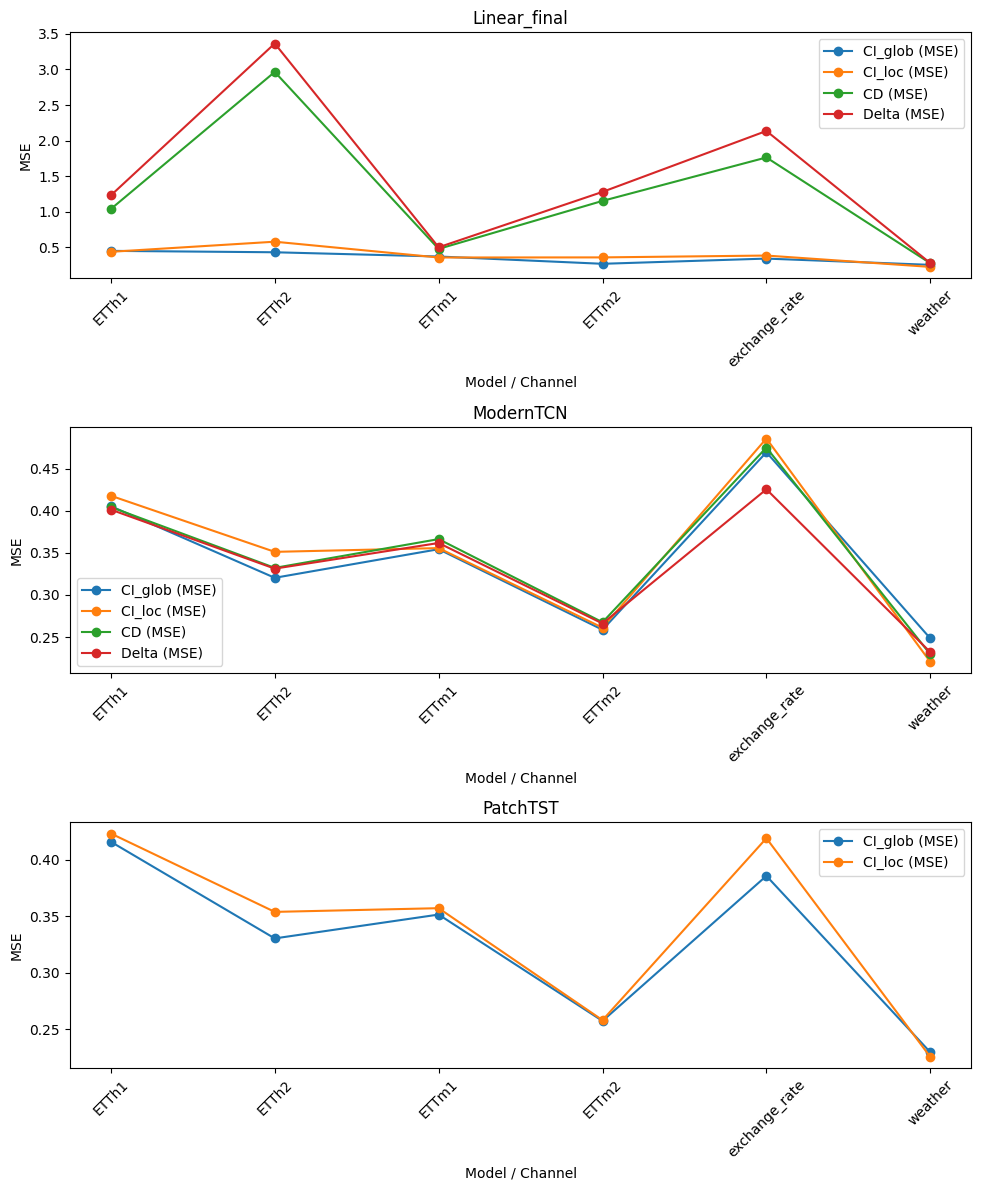

In [36]:
df_avg.head()


data_path_list = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "national_illness"]
data_path_list = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather"]

model_list = ["Linear_final", "ModernTCN", "PatchTST"] 

n = len(model_list)
fig, axes = plt.subplots(n, 1, figsize=(10, 4 * n), squeeze=False)  # single column, multiple rows

for idx, model in enumerate(model_list):
    ax = axes[idx][0]

    df_plot = df_avg[(df_avg["model"] == model) &
                     (df_avg["cd_weight_decay"] == 0.0) &
                     (df_avg["data_path"].isin(data_path_list))].copy()

    if df_plot.empty:
        ax.set_title(f"{data_path} (no data)")
        ax.axis("off")
        continue
    
    
    for channel_handling in df_plot['channel_handling'].unique():
        df_channel = df_plot[df_plot['channel_handling'] == channel_handling]
        ax.plot(df_channel['data_path'], df_channel['mse'], label=channel_handling + " (MSE)", marker='o')
        #ax.plot(df_channel['data_path'], df_channel['mse_train'], label=channel_handling + " (MSE train)", marker='x')
    
    ax.set_title(model)
    ax.legend()
    ax.set_xlabel('Model / Channel')
    ax.set_ylabel('MSE')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("plots/Other/models_test.png")
plt.show()


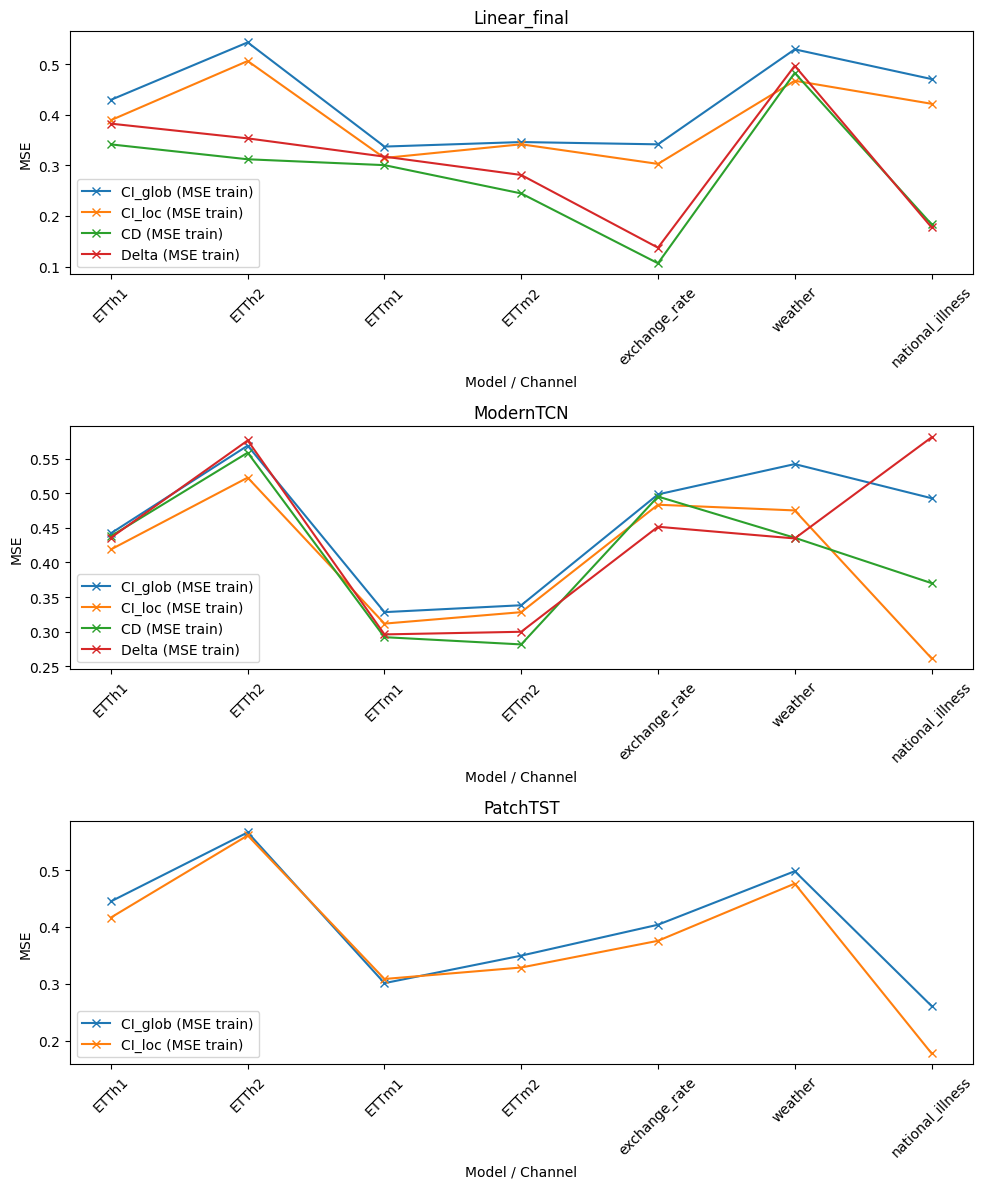

In [23]:
df_avg.head()


data_path_list = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "national_illness"]

model_list = ["Linear_final", "ModernTCN", "PatchTST"] 

n = len(model_list)
fig, axes = plt.subplots(n, 1, figsize=(10, 4 * n), squeeze=False)  # single column, multiple rows

for idx, model in enumerate(model_list):
    ax = axes[idx][0]

    df_plot = df_avg[(df_avg["model"] == model) &
                     (df_avg["cd_weight_decay"] == 0.0) &
                     (df_avg["data_path"].isin(data_path_list))].copy()

    if df_plot.empty:
        ax.set_title(f"{data_path} (no data)")
        ax.axis("off")
        continue
    
    
    for channel_handling in df_plot['channel_handling'].unique():
        df_channel = df_plot[df_plot['channel_handling'] == channel_handling]
        #ax.plot(df_channel['data_path'], df_channel['mse'], label=channel_handling + " (MSE)", marker='o')
        ax.plot(df_channel['data_path'], df_channel['mse_train'], label=channel_handling + " (MSE train)", marker='x')
    
    ax.set_title(model)
    ax.legend()
    ax.set_xlabel('Model / Channel')
    ax.set_ylabel('MSE')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("plots/Other/models_train.png")
plt.show()


/scratch/ipykernel_383591/3122857556.py:21: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x, y, yerr=yerr, fmt='o', capsize=5, linestyle='-', marker='o')


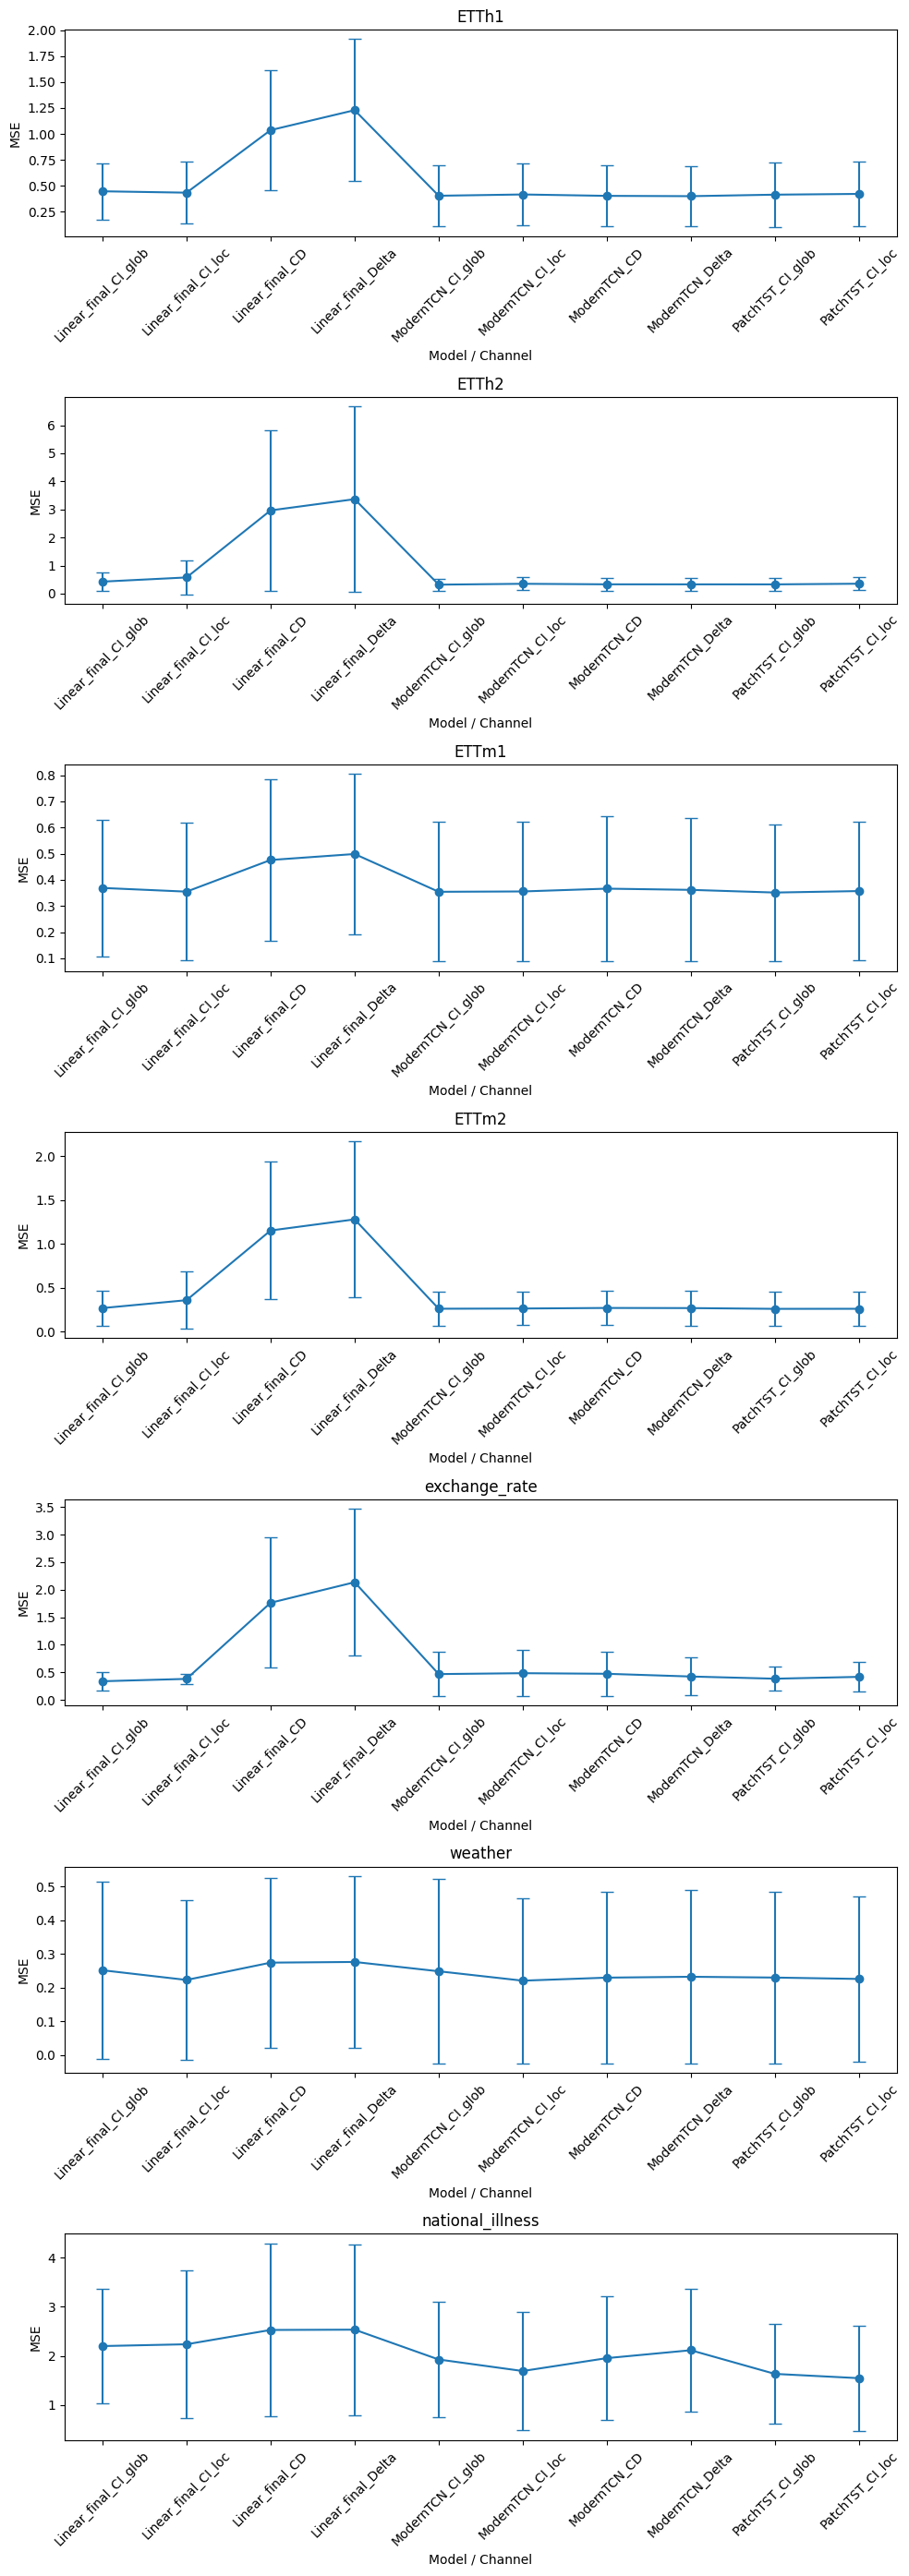

In [24]:

data_path_list = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "national_illness"]

n = len(data_path_list)
fig, axes = plt.subplots(n, 1, figsize=(10, 4 * n), squeeze=False)  # single column, multiple rows

for idx, data_path in enumerate(data_path_list):
    ax = axes[idx][0]

    df_plot = df_avg[(df_avg["data_path"] == data_path) &
                     (df_avg["cd_weight_decay"] == 0.0)].copy()

    if df_plot.empty:
        ax.set_title(f"{data_path} (no data)")
        ax.axis("off")
        continue

    x = df_plot['model_CH']
    y = df_plot['mse']
    yerr = df_plot['mse_per_channel_std']

    ax.errorbar(x, y, yerr=yerr, fmt='o', capsize=5, linestyle='-', marker='o')
    ax.set_title(data_path)
    ax.set_xlabel('Model / Channel')
    ax.set_ylabel('MSE')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("plots/Other/models_errorbar.png")
plt.show()


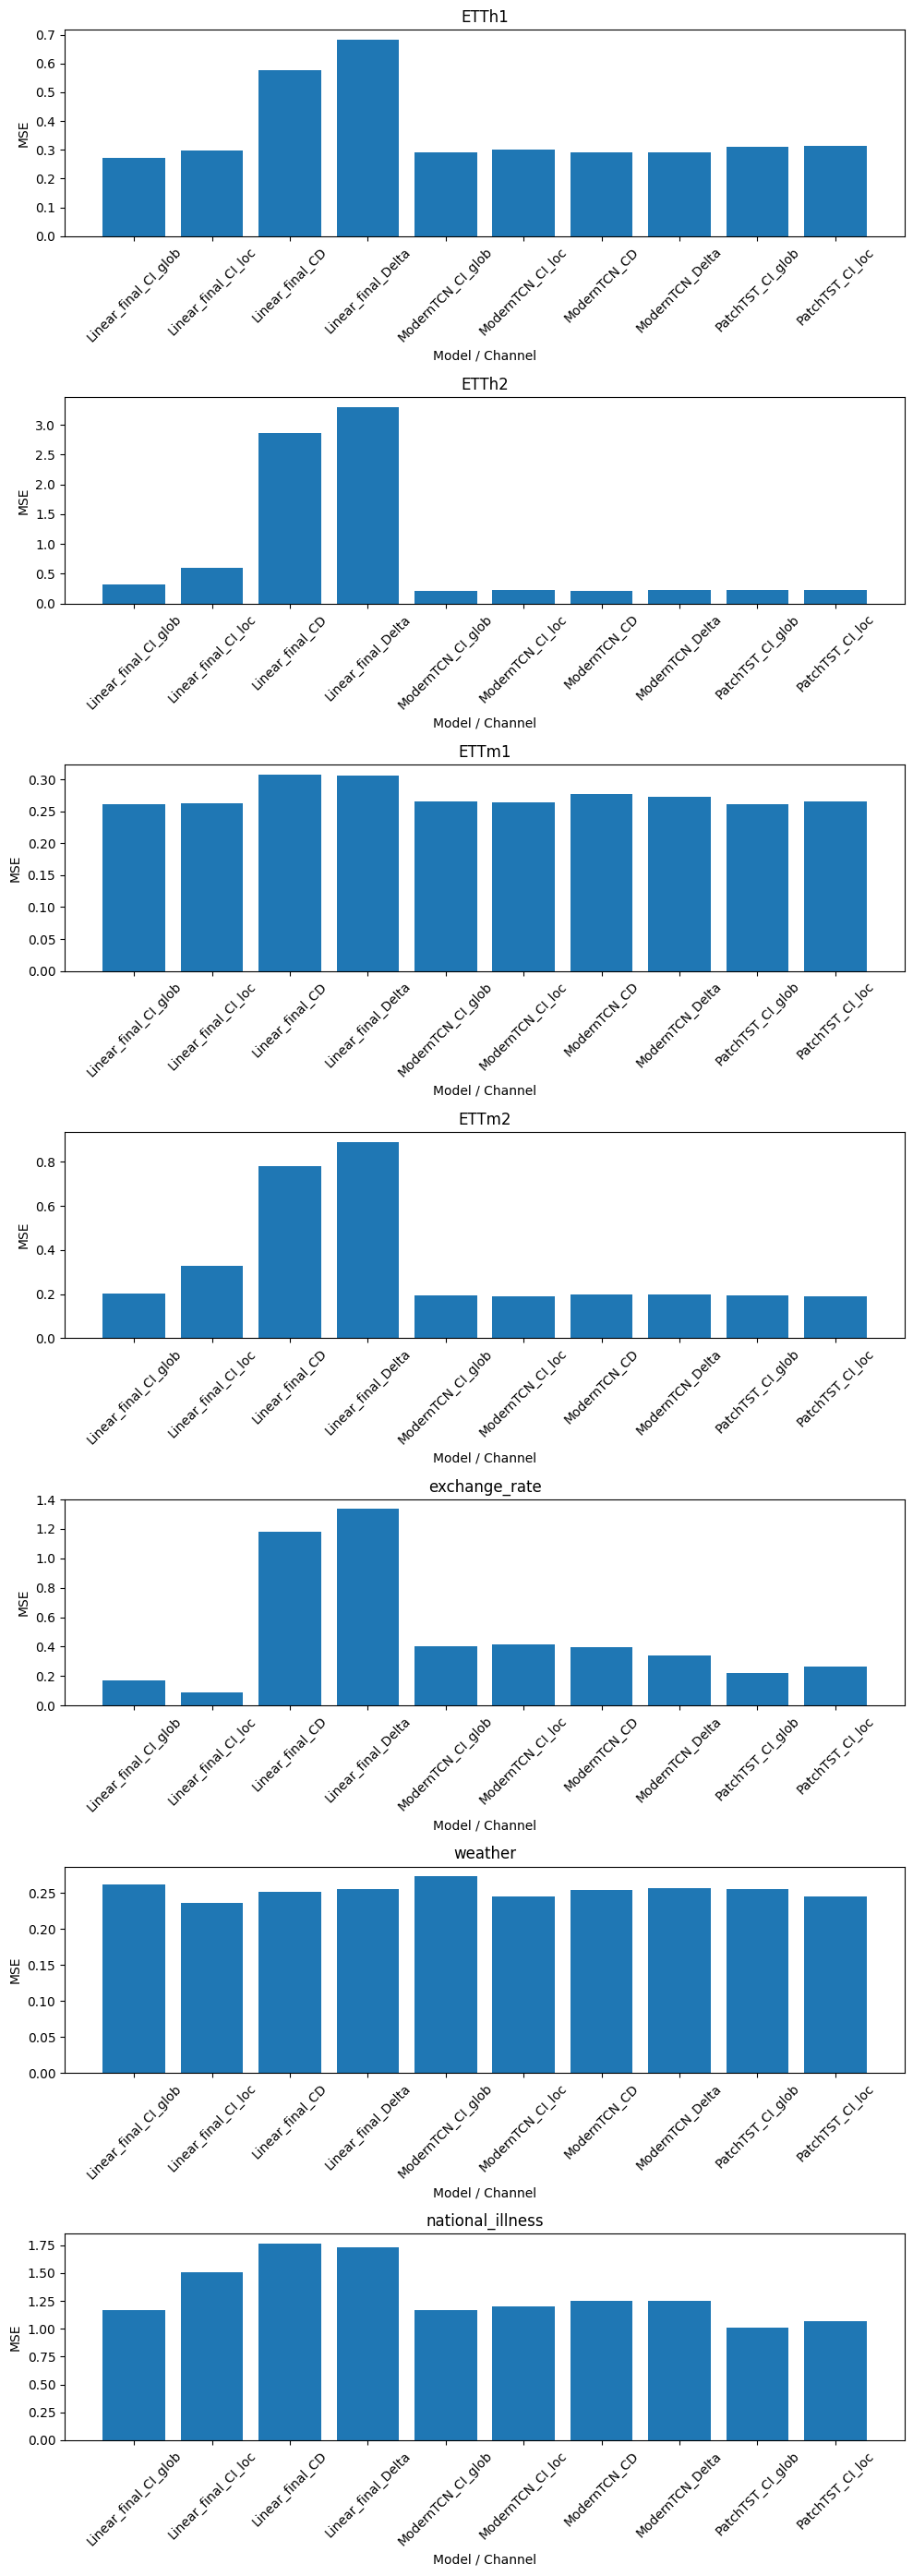

In [25]:

data_path_list = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "national_illness"]

n = len(data_path_list)
fig, axes = plt.subplots(n, 1, figsize=(10, 4 * n), squeeze=False)  # single column, multiple rows

for idx, data_path in enumerate(data_path_list):
    ax = axes[idx][0]

    df_plot = df_avg[(df_avg["data_path"] == data_path) &
                     (df_avg["cd_weight_decay"] == 0.0)].copy()

    if df_plot.empty:
        ax.set_title(f"{data_path} (no data)")
        ax.axis("off")
        continue

    x = df_plot['model_CH']
    y = df_plot['mse']
    yerr = df_plot['mse_per_channel_std']

    ax.bar(x, yerr)
    ax.set_title(data_path)
    ax.set_xlabel('Model / Channel')
    ax.set_ylabel('MSE')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("plots/Other/models_std.png")
plt.show()


## Table

In [26]:


def table(channel_handling = "CI_glob", df_avg=df_avg, df_subset=df_subset):
    list_pred_len = [96, 192, 336, 720, "Avg"]
    list_data_path = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "traffic", "electricity"]
    index_labels = [f"{data_path} - {pred_len}" for data_path in list_data_path for pred_len in list_pred_len]

    list_pred_len = [24, 36, 48, 60, "Avg"]
    list_data_path = ["national_illness"]
    index_labels = index_labels + [f"{data_path} - {pred_len}" for data_path in list_data_path for pred_len in list_pred_len]

    # Example: define some columns
    columns = [f"{model} - {metric}" for model in ["Linear_final", "ModernTCN", "PatchTST"] for metric in ["MSE", "MAE"]]

    df_table = pd.DataFrame(index=index_labels, columns=columns)

    for data_path in ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "traffic", "electricity", "national_illness"]:
        if data_path == "national_illness":
            list_pred_len = [24, 36, 48, 60, "Avg"]
        else:
            list_pred_len = [96, 192, 336, 720, "Avg"]

        for pred_len in list_pred_len:
            for model in ["Linear_final", "ModernTCN", "PatchTST"]:
                if pred_len == "Avg":
                    df_filtered = df_avg[
                        (df_avg['data_path'].str.contains(data_path)) &
                        (df_avg['model'] == model) &
                        (df_avg['channel_handling'] == channel_handling)
                    ]
                else:
                    df_filtered = df_subset[
                        (df_subset['data_path'].str.contains(data_path)) &
                        (df_subset['pred_len'] == pred_len) &
                        (df_subset['model'] == model) &
                        (df_subset['channel_handling'] == channel_handling)
                    ]
                    #display(df_filtered)

                if not df_filtered.empty:
                    mse = df_filtered['mse'].values[0]
                    mae = df_filtered['mae'].values[0]
                    df_table.loc[f"{data_path} - {pred_len}", f"{model} - MSE"] = round(mse, 3)
                    df_table.loc[f"{data_path} - {pred_len}", f"{model} - MAE"] = round(mae, 3)

    return df_table

def render_table(df, title="", fontsize=10, show:bool=False):
    fig, ax = plt.subplots(figsize=(len(df.columns)*1.8, len(df)*0.3))  # Adjust figure size
    ax.axis('off')  # Hide axes

    table = plt.table(
        cellText=df.values,
        rowLabels=df.index,
        colLabels=df.columns,
        cellLoc='center',
        loc='center'
    )

    table.auto_set_font_size(False)
    table.set_fontsize(fontsize)
    table.scale(1.2, 1.2)  # Adjust scaling for better readability

    if title:
        plt.title(title, fontsize=fontsize+2)

    save_dir = f"plots/tables"
    os.makedirs(save_dir, exist_ok=True)
    save_path = f"{save_dir}/{channel_handling}.png"
    plt.savefig(save_path)

    plt.tight_layout()
    
    if show:
        plt.show()
    else:
        plt.close(fig)

#render_table(table(), title="Results for CI_glob Channel Handling", fontsize=10);

In [27]:
vf.render_table(vf.table(channel_handling="CI_glob", df_avg=df_avg, df_subset=df_subset), title="Results for CI_glob", fontsize=10)

## Comp (PatchTST, ModernTCN)

In [28]:


def comp_PatchTST(df_avg=df_avg, df_subset=df_subset):
    list_pred_len = [96, 192, 336, 720, "Avg"]
    list_data_path = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "weather", "traffic", "electricity"]      # , "exchange_rate"
    index_labels = [f"{data_path} - {pred_len}" for data_path in list_data_path for pred_len in list_pred_len]

    list_pred_len = [24, 36, 48, 60, "Avg"]
    list_data_path = ["national_illness"]
    index_labels = index_labels + [f"{data_path} - {pred_len}" for data_path in list_data_path for pred_len in list_pred_len]

    model = "PatchTST"
    channel_handling = "CI_glob"
    columns = ["MSE - sk", "MSE - paper", "MSE - %", "MAE - sk", "MAE - paper", "MAE - %"]
    # ref PatchTST/42

    df_table = pd.DataFrame(index=index_labels, columns=columns)

    for data_path in ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "weather", "traffic", "electricity", "national_illness"]:     # "exchange_rate" isn't evaluated in the paper
        if data_path == "national_illness":
            list_pred_len = [24, 36, 48, 60, "Avg"]
        else:
            list_pred_len = [96, 192, 336, 720, "Avg"]

        for pred_len in list_pred_len:
            if pred_len == "Avg":
                df_filtered = df_avg[
                    (df_avg['data_path'].str.contains(data_path)) &
                    (df_avg['model'] == model) &
                    (df_avg['channel_handling'] == channel_handling)
                ]
            else:
                df_filtered = df_subset[
                    (df_subset['data_path'].str.contains(data_path)) &
                    (df_subset['pred_len'] == pred_len) &
                    (df_subset['model'] == model) &
                    (df_subset['channel_handling'] == channel_handling)
                ]

            if not df_filtered.empty:
                mse = df_filtered['mse'].values[0]
                mae = df_filtered['mae'].values[0]
                df_table.loc[f"{data_path} - {pred_len}", f"MSE - sk"] = round(mse, 3)
                df_table.loc[f"{data_path} - {pred_len}", f"MAE - sk"] = round(mae, 3)

            
            mse = df_ref[
                (df_ref['data_path'].str.contains(data_path)) &
                (df_ref['pred_len'] == str(pred_len)) &
                (df_ref['model'] == "PatchTST/42")
            ]['mse'].values[0]
            mae = df_ref[
                (df_ref['data_path'].str.contains(data_path)) &
                (df_ref['pred_len'] == str(pred_len)) &
                (df_ref['model'] == "PatchTST/42")
            ]['mae'].values[0]

            #print(f"Processing {data_path} - {pred_len}, MSE: {mse}, MAE: {mae}")


            df_table.loc[f"{data_path} - {pred_len}", f"MSE - paper"] = round(mse, 3)
            df_table.loc[f"{data_path} - {pred_len}", f"MAE - paper"] = round(mae, 3)   

            mse_perc = df_table.loc[f"{data_path} - {pred_len}", f"MSE - sk"] / df_table.loc[f"{data_path} - {pred_len}", f"MSE - paper"] - 1
            mae_perc = df_table.loc[f"{data_path} - {pred_len}", f"MAE - sk"] / df_table.loc[f"{data_path} - {pred_len}", f"MAE - paper"] - 1

            df_table.loc[f"{data_path} - {pred_len}", f"MSE - %"] = round(mse_perc * 100, 2)
            df_table.loc[f"{data_path} - {pred_len}", f"MAE - %"] = round(mae_perc * 100, 2)

    return df_table




def comp_ModernTCN(df_avg=df_avg, df_subset=df_subset):
    list_pred_len = [96, 192, 336, 720, "Avg"]
    list_data_path = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "weather", "traffic", "electricity", "exchange_rate"]
    index_labels = [f"{data_path} - {pred_len}" for data_path in list_data_path for pred_len in list_pred_len]

    list_pred_len = [24, 36, 48, 60, "Avg"]
    list_data_path = ["national_illness"]
    index_labels = index_labels + [f"{data_path} - {pred_len}" for data_path in list_data_path for pred_len in list_pred_len]

    model = "ModernTCN"
    channel_handling = "CD"
    cd_weight_decay = 0.0
    columns = ["MSE - sk", "MSE - paper", "MSE - %", "MAE - sk", "MAE - paper", "MAE - %"]
    # ref PatchTST/42

    df_table = pd.DataFrame(index=index_labels, columns=columns)

    for data_path in ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "weather", "traffic", "electricity", "national_illness", "exchange_rate"]:
        if data_path == "national_illness":
            list_pred_len = [24, 36, 48, 60, "Avg"]
        else:
            list_pred_len = [96, 192, 336, 720, "Avg"]

        for pred_len in list_pred_len:
            if pred_len == "Avg":
                df_filtered = df_avg[
                    (df_avg['data_path'].str.contains(data_path)) &
                    (df_avg['model'] == model) &
                    (df_avg['channel_handling'] == channel_handling) &
                    (df_avg['cd_weight_decay'] == cd_weight_decay)
                ]
            else:
                df_filtered = df_subset[
                    (df_subset['data_path'].str.contains(data_path)) &
                    (df_subset['pred_len'] == pred_len) &
                    (df_subset['model'] == model) &
                    (df_subset['channel_handling'] == channel_handling) &
                    (df_subset['cd_weight_decay'] == cd_weight_decay)
                ]

            if not df_filtered.empty:
                mse = df_filtered['mse'].values[0]
                mae = df_filtered['mae'].values[0]
                df_table.loc[f"{data_path} - {pred_len}", f"MSE - sk"] = round(mse, 3)
                df_table.loc[f"{data_path} - {pred_len}", f"MAE - sk"] = round(mae, 3)
            
            mse = df_ref[
                (df_ref['data_path'].str.contains(data_path)) &
                (df_ref['pred_len'] == str(pred_len)) &
                (df_ref['model'] == model)
            ]['mse'].values[0]
            mae = df_ref[
                (df_ref['data_path'].str.contains(data_path)) &
                (df_ref['pred_len'] == str(pred_len)) &
                (df_ref['model'] == model)
            ]['mae'].values[0]

            print(f"Processing {data_path} - {pred_len}, MSE: {mse}, MAE: {mae}")


            df_table.loc[f"{data_path} - {pred_len}", f"MSE - paper"] = round(mse, 3)
            df_table.loc[f"{data_path} - {pred_len}", f"MAE - paper"] = round(mae, 3)   

            mse_perc = df_table.loc[f"{data_path} - {pred_len}", f"MSE - sk"] / df_table.loc[f"{data_path} - {pred_len}", f"MSE - paper"] - 1
            mae_perc = df_table.loc[f"{data_path} - {pred_len}", f"MAE - sk"] / df_table.loc[f"{data_path} - {pred_len}", f"MAE - paper"] - 1

            df_table.loc[f"{data_path} - {pred_len}", f"MSE - %"] = round(mse_perc * 100, 2)
            df_table.loc[f"{data_path} - {pred_len}", f"MAE - %"] = round(mae_perc * 100, 2)

    return df_table

In [29]:
vf.render_table(comp_PatchTST(df_avg=df_avg, df_subset=df_subset), title="PatchTST_Comp", fontsize=10)
vf.render_table(comp_ModernTCN(df_avg=df_avg, df_subset=df_subset), title="ModernTCN_Comp", fontsize=10)

Processing ETTh1 - 96, MSE: 0.368, MAE: 0.394
Processing ETTh1 - 192, MSE: 0.405, MAE: 0.413
Processing ETTh1 - 336, MSE: 0.391, MAE: 0.412
Processing ETTh1 - 720, MSE: 0.45, MAE: 0.461
Processing ETTh1 - Avg, MSE: 0.404, MAE: 0.42
Processing ETTh2 - 96, MSE: 0.263, MAE: 0.332
Processing ETTh2 - 192, MSE: 0.32, MAE: 0.374
Processing ETTh2 - 336, MSE: 0.313, MAE: 0.376
Processing ETTh2 - 720, MSE: 0.392, MAE: 0.433
Processing ETTh2 - Avg, MSE: 0.322, MAE: 0.379
Processing ETTm1 - 96, MSE: 0.292, MAE: 0.346
Processing ETTm1 - 192, MSE: 0.332, MAE: 0.368
Processing ETTm1 - 336, MSE: 0.365, MAE: 0.391
Processing ETTm1 - 720, MSE: 0.416, MAE: 0.417
Processing ETTm1 - Avg, MSE: 0.351, MAE: 0.381
Processing ETTm2 - 96, MSE: 0.166, MAE: 0.256
Processing ETTm2 - 192, MSE: 0.222, MAE: 0.293
Processing ETTm2 - 336, MSE: 0.272, MAE: 0.324
Processing ETTm2 - 720, MSE: 0.351, MAE: 0.381
Processing ETTm2 - Avg, MSE: 0.253, MAE: 0.314
Processing weather - 96, MSE: 0.149, MAE: 0.2
Processing weather - 

In [30]:
# CI_glob, CI_loc, CD, Delta (letzte beide inkl. cd_weight_decay)
# versch. random seeds

# versch. lags & pred_len

data_path_list = "_weather_shower_lag"

cd_weight_decay = 0.0
random_seed = 2021

df_subset[df_subset['data_path'].str.contains(data_path)]

,model,pred_len,random_seed,data_path,mae,mse,seq_len,cd_weight_decay,mse_train,mae_train,...,mse_per_channel_list,mae_train_per_channel_list,mae_per_channel_list,channel_handling,learning_rate,batch_size,patience,head_dropout,dropout,delta_factor
543,PatchTST,24,2021,national_illness,0.803709,1.526970,104,0.0,0.178466,0.266468,...,"[0.5992899537086487, 0.9297056794166564, 2.638...","[0.323392391204834, 0.3177845776081085, 0.2902...","[0.5129213929176331, 0.6478416323661804, 1.175...",CI_loc,0.0025,16,20,0.0,0.30,1.0
546,PatchTST,24,2021,national_illness,0.734400,1.300964,104,0.0,0.147548,0.268095,...,"[0.6042349934577942, 0.8341977000236511, 1.866...","[0.32734137773513794, 0.3444662392139435, 0.26...","[0.48295941948890686, 0.5699107646942139, 0.94...",CI_glob,0.0025,16,20,0.0,0.30,1.0
549,PatchTST,36,2021,national_illness,0.738304,1.402446,104,0.0,0.139886,0.241957,...,"[0.5639632344245911, 0.859851062297821, 2.7312...","[0.2924741208553314, 0.275689035654068, 0.2251...","[0.4654504358768463, 0.5817347168922424, 1.171...",CI_loc,0.0025,16,20,0.0,0.30,1.0
553,PatchTST,36,2021,national_illness,0.897628,1.658348,104,0.0,0.301664,0.343836,...,"[0.7302098274230957, 0.9953809380531312, 1.986...","[0.3963671922683716, 0.40513041615486145, 0.34...","[0.6038227677345276, 0.698068380355835, 1.0487...",CI_glob,0.0025,16,20,0.0,0.30,1.0
556,PatchTST,48,2021,national_illness,0.781294,1.551446,104,0.0,0.108178,0.218677,...,"[0.5542073845863342, 0.8795433640480042, 2.753...","[0.27350935339927673, 0.2145286351442337, 0.19...","[0.499705582857132, 0.5648725032806396, 1.1448...",CI_loc,0.0025,16,20,0.0,0.30,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4848,ModernTCN,36,2025,national_illness,0.980895,2.162097,104,0.0,0.628534,0.475878,...,"[0.952479898929596, 1.188323974609375, 3.02190...","[0.5435545444488525, 0.5766631960868835, 0.437...","[0.6319341659545898, 0.7097926735877991, 1.191...",Delta,0.0025,32,5,0.0,0.10,0.5
4849,ModernTCN,48,2025,national_illness,0.811411,1.412726,104,0.0,0.298713,0.335362,...,"[0.6622068881988525, 0.8514477610588074, 2.217...","[0.39677730202674866, 0.4160751402378082, 0.33...","[0.5790196061134338, 0.6450638175010681, 1.082...",Delta,0.0025,32,5,0.0,0.10,0.5
4850,ModernTCN,60,2025,national_illness,1.038023,2.305511,104,0.0,0.653062,0.493788,...,"[0.8682615756988525, 1.140823245048523, 3.5010...","[0.5627562999725342, 0.5844948887825012, 0.454...","[0.6263439059257507, 0.7083324790000916, 1.313...",Delta,0.0025,32,5,0.0,0.10,0.5
4872,Linear_final,24,2021,national_illness,0.938712,2.196550,36,0.0,0.270700,0.296207,...,"[1.1863101720809937, 1.432734131813049, 2.8447...","[0.36054256558418274, 0.3742435574531555, 0.28...","[0.7532585263252258, 0.7931244969367981, 1.198...",CD,0.0050,32,20,0.0,0.05,1.0


In [31]:
pred_len_list = 96
data_path_list = ["_weather_shower_lag"]


def lag(pred_len=pred_len, data_path_list=data_path_list, df_subset=df_subset, model="Linear_final"):
    fig, axs = plt.subplots(4, figsize=(10, 10), sharey=True)
    #fig, axs = plt.subplots(4, figsize=(10, 10))#, sharey=True)

    
    for j, data_path in enumerate(data_path_list):
        for ind, channel_handling in enumerate(["CI_glob", "CI_loc", "CD", "Delta"]):
            df_CI = df_subset[(df_subset['model'] == model) & (df_subset['channel_handling'] == channel_handling) & (df_subset['cd_weight_decay'] == 0.0) & (df_subset['random_seed'] == 2021) 
                              & (df_subset['data_path'].str.contains(data_path)) & (df_subset['pred_len'] == pred_len) & (df_subset['patience'] == 20)].copy()
            #df_CI['data_lag'] = df_CI['data_path'].str.extract(r'_([0-9]+)$').astype(int)
            df_CI['data_lag'] = df_CI['data_path'].str.extract(r'_lag_([0-9]+)')[0].astype(int)
            df_CI = df_CI.sort_values(by='data_lag')

            #display(df_CI)

            data_train = df_CI["mse_train_per_channel_list"].tolist()
            data_test = df_CI["mse_per_channel_list"].tolist()
            combined = [d1 + d2 for d1, d2 in zip(data_train, data_test)]
            
            data = list(map(list, zip(*combined)))        # "Transpose" the list of lists
            #display(data)

            x_labels = df_CI['data_lag'].astype(str).tolist()
            
            #group_labels = ['NoLag_train', 'Lag_train', 'NoLag_test', 'Lag_test']
            group_labels = ['NoLag_train', 'Lag_train', 'NoLag_test', 'Lag_test']

            bar_width = 0.15
            x = np.arange(len(x_labels))

            # Plot using a loop
            for l, group in enumerate(data):
                offset = (l - len(data)/2 + 0.5) * bar_width
                axs[ind].bar(x + offset, group, width=bar_width, label=group_labels[l])

            axs[ind].set_xticks(x)
            axs[ind].set_xticklabels(x_labels)
            axs[ind].set_title(f'{model} - {channel_handling} - Pred Len: {pred_len}, Data: {data_path}')
            axs[ind].set_ylabel(metric)
            axs[ind].set_xlabel("Data lag")
            axs[ind].legend()
            axs[ind].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig("plots/Dataset_Selec/"+model+"_pred"+str(pred_len)+".png")
    #plt.show()

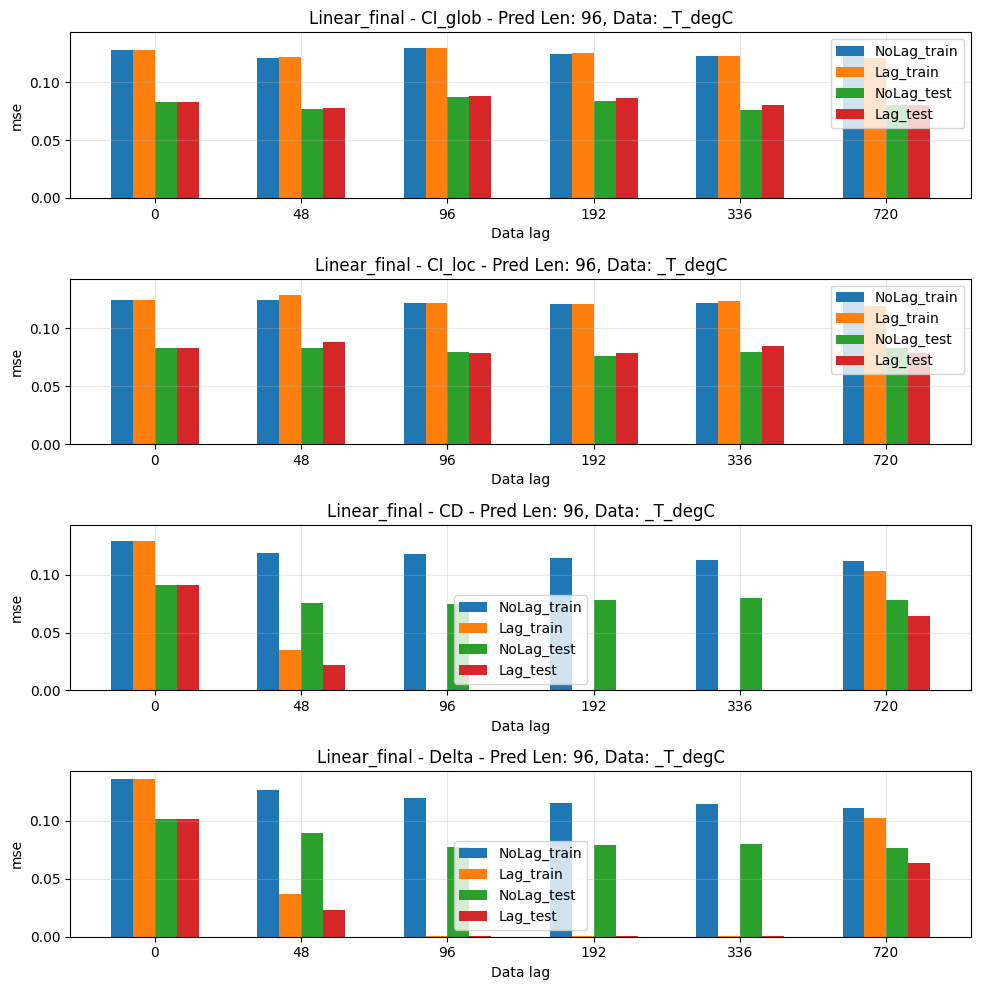

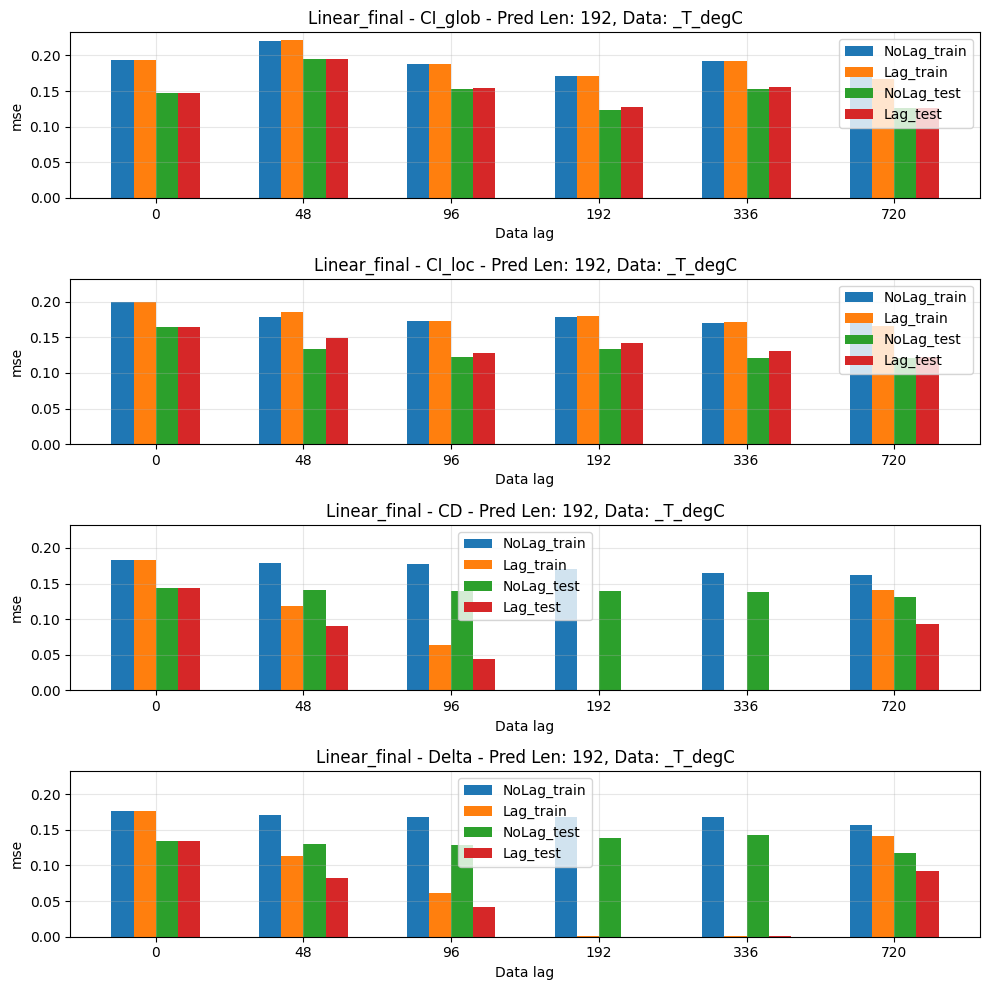

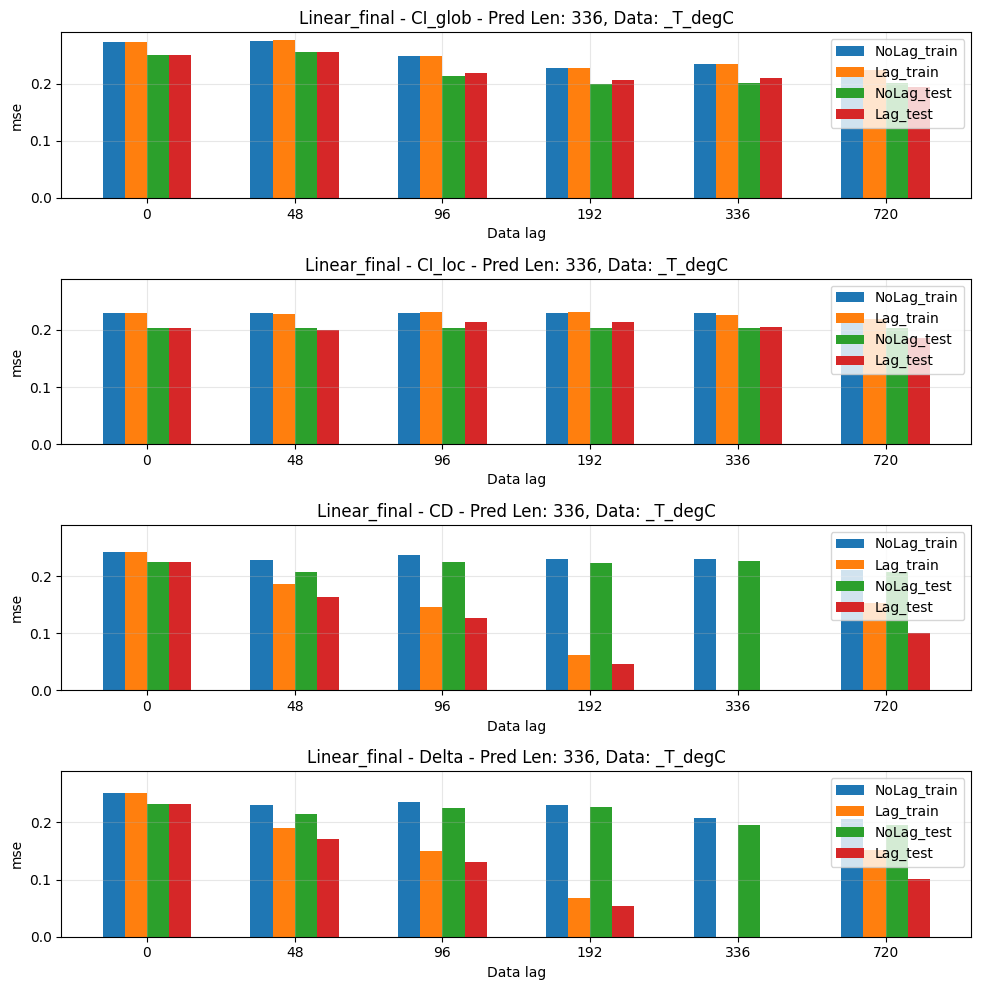

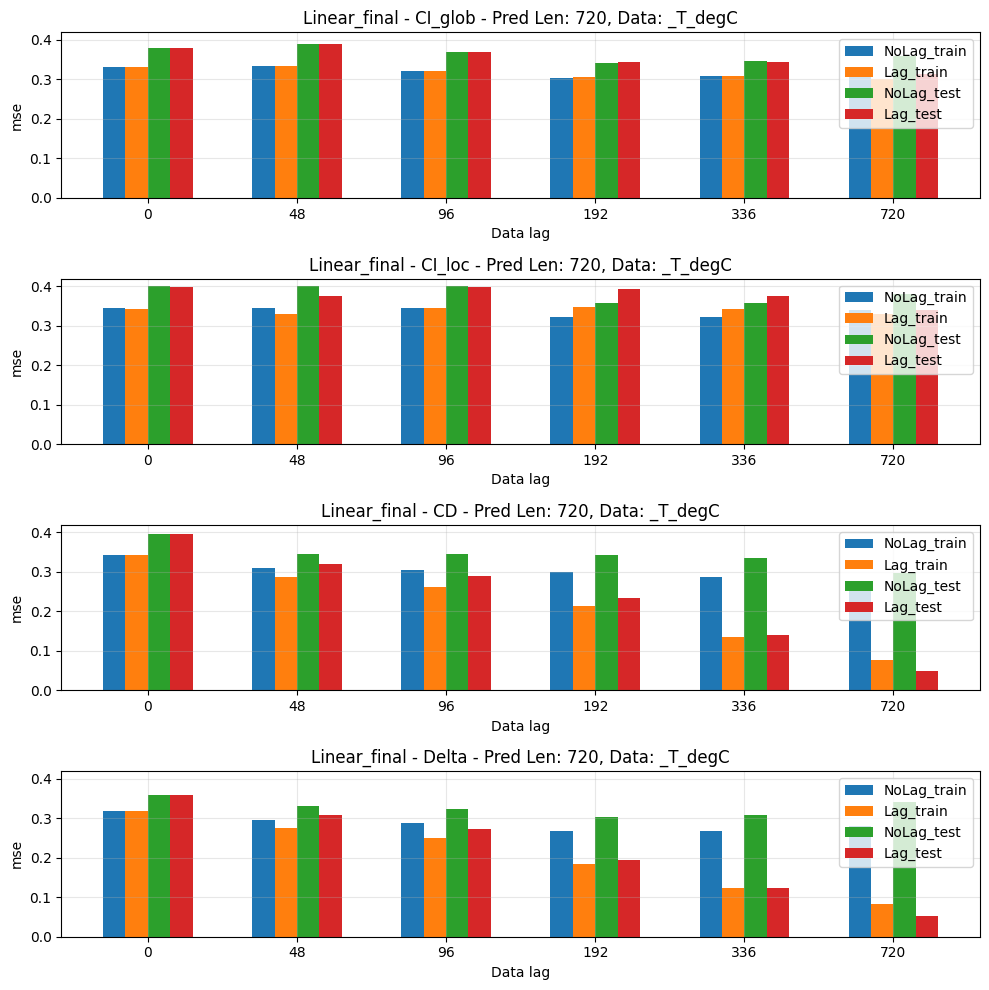

In [32]:
for pred_len in [96, 192, 336, 720]:
    lag(model="Linear_final", data_path_list=["_T_degC"], pred_len=pred_len)

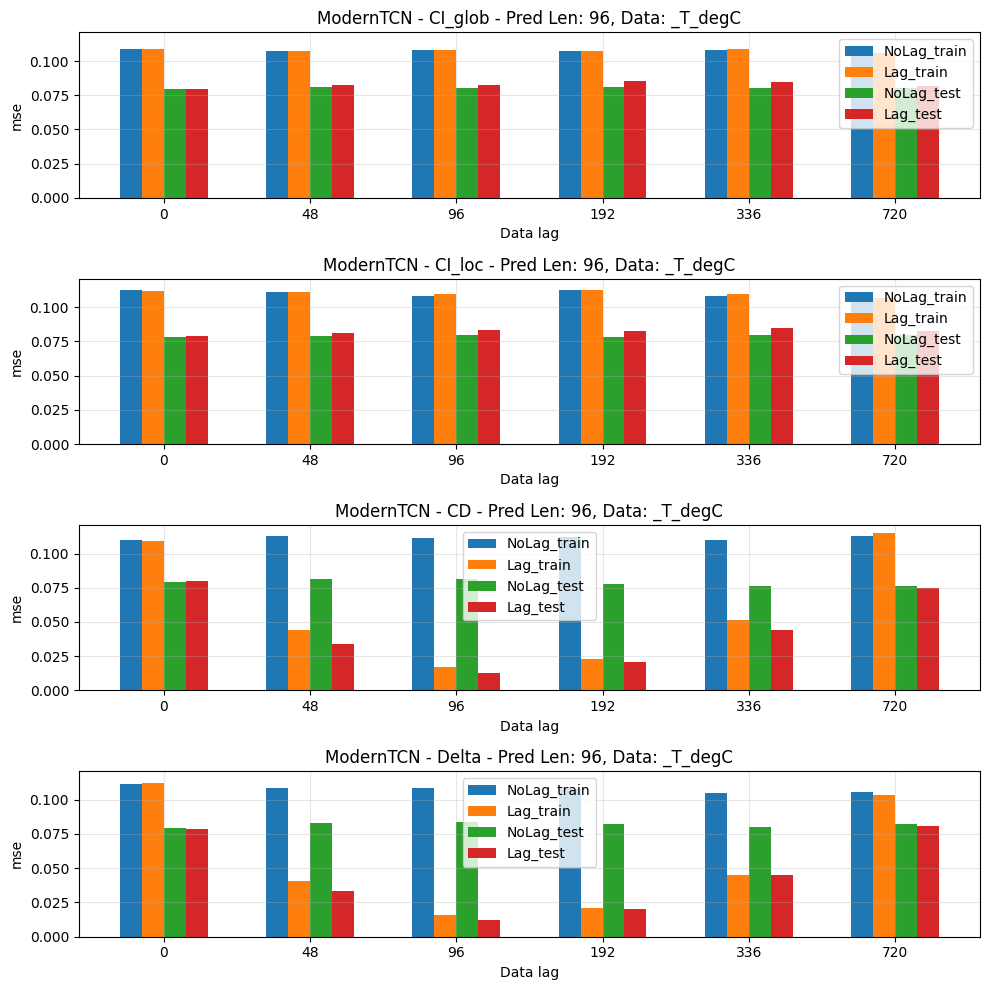

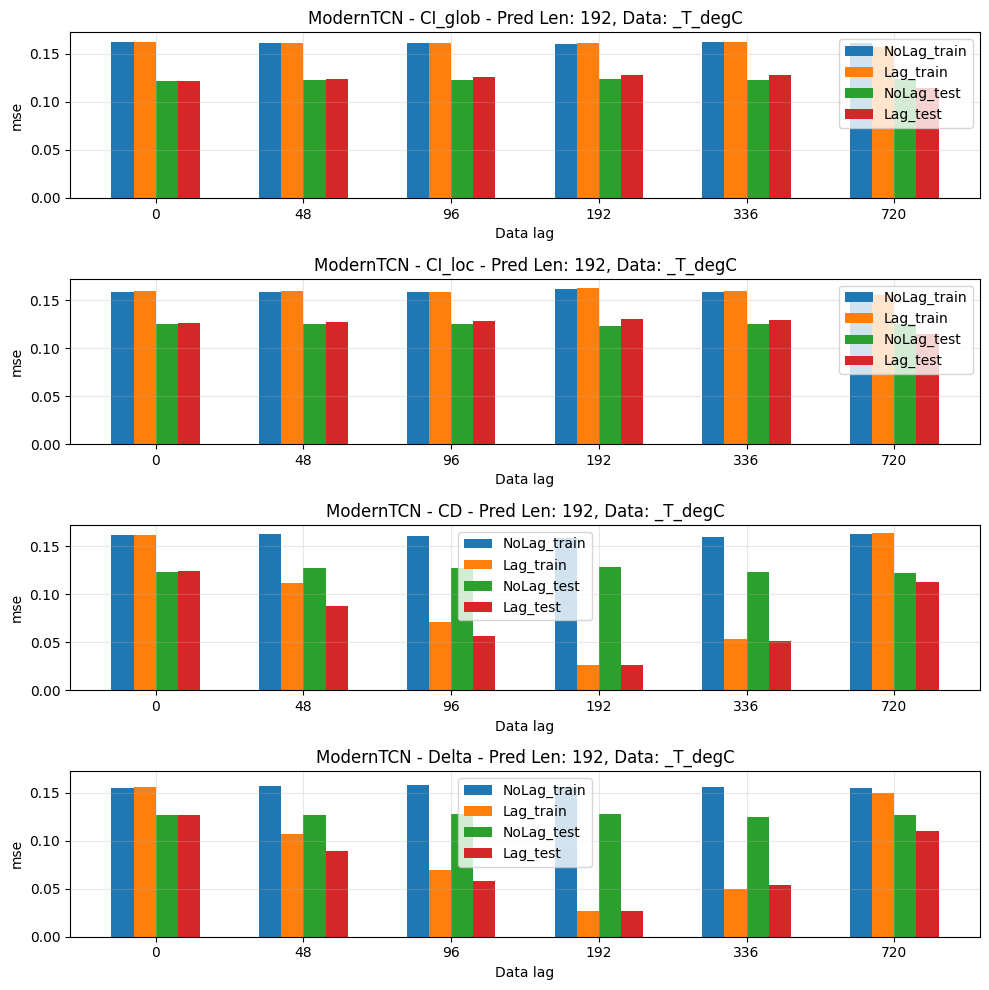

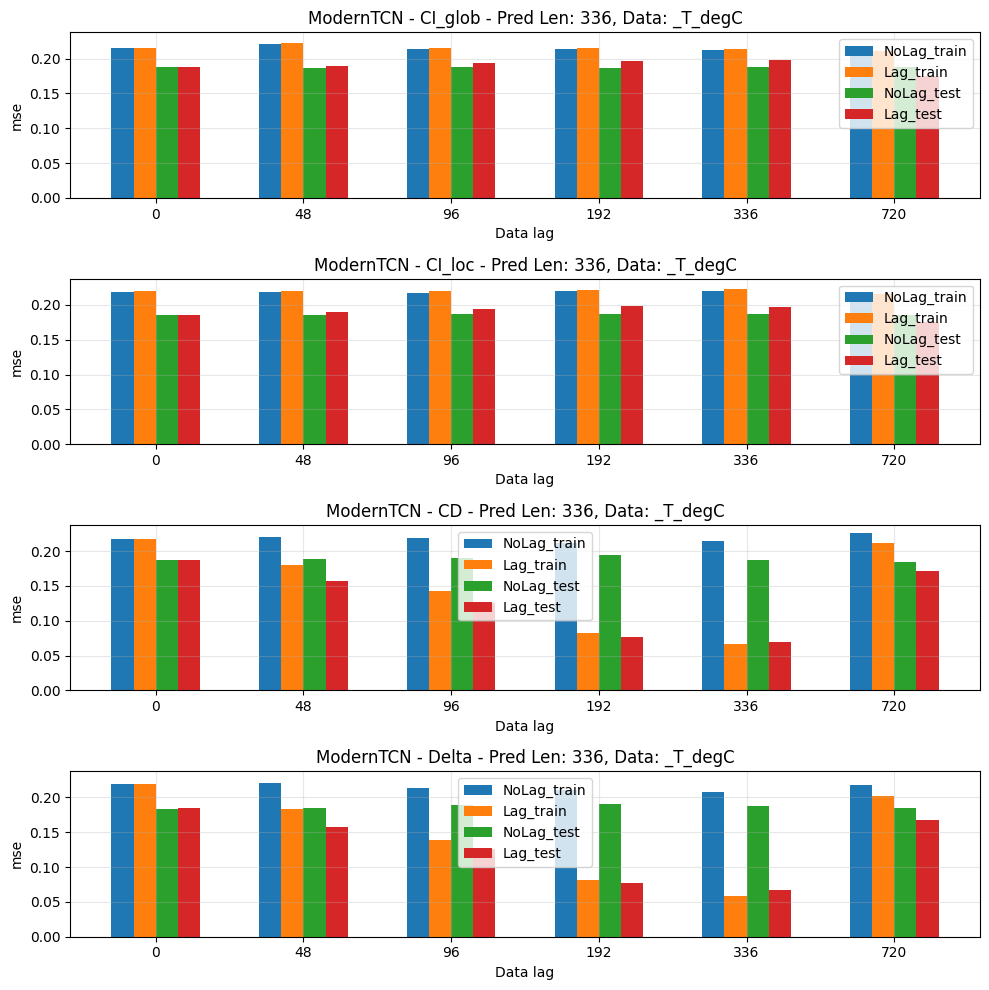

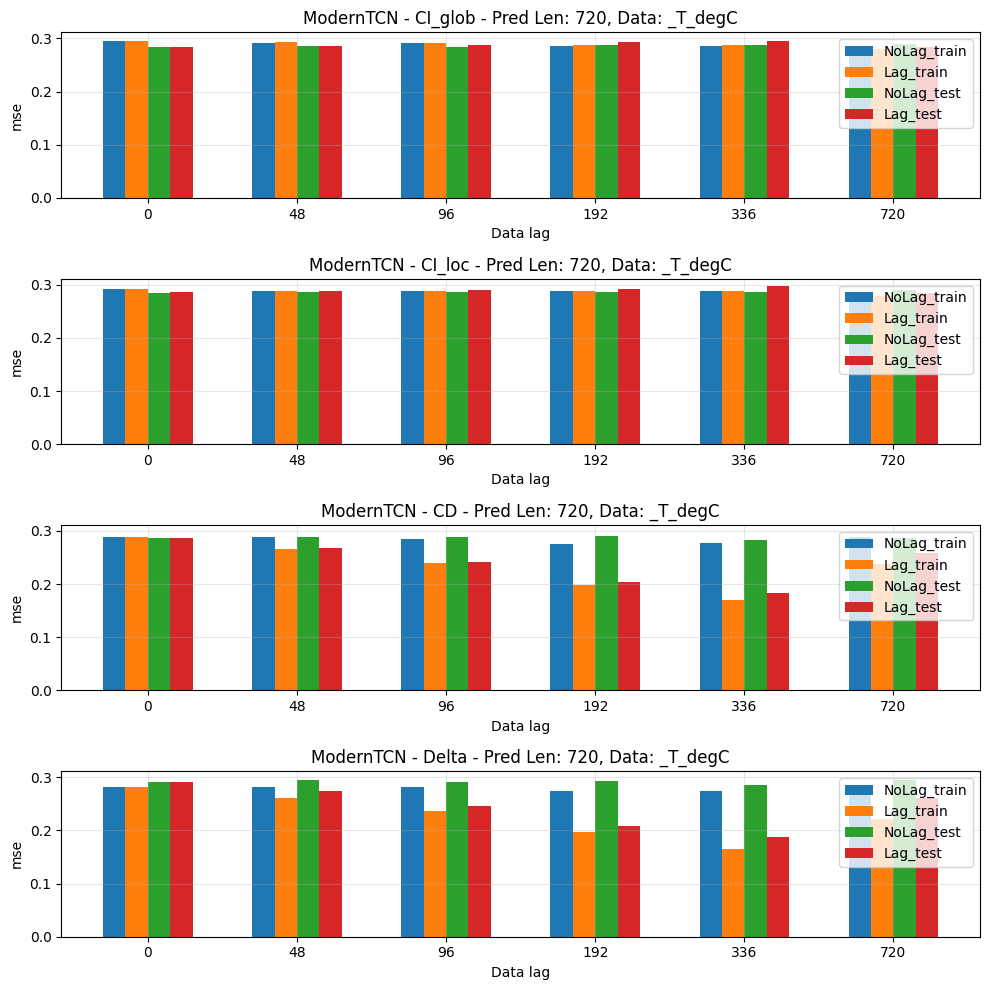

In [33]:
for pred_len in [96, 192, 336, 720]:
    lag(model="ModernTCN", data_path_list=["_T_degC"], pred_len=pred_len)

In [34]:
base_path = "/pfs/work9/workspace/scratch/ma_skral-SK_thesis_2025/Thesis_MTSF/PatchTST/PatchTST_supervised/checkpoints"

matches = [
    folder for folder in os.listdir(base_path)
    if os.path.isdir(os.path.join(base_path, folder)) and
       #all(key in folder for key in ["TCN", "720", "raffic", "CD"])
       all(key in folder for key in ["TCN", "raffic"])
       #all(key in folder for key in ["TCN", "lectricity"])
]

matches.sort()

for match in matches:
    print(match)

Traffic_336_192_ModernTCN_custom_ftM_sl336_ll48_pl192_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chCD_cdwd0.0_Exp_0
Traffic_336_192_ModernTCN_custom_ftM_sl336_ll48_pl192_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chCI_glob_cdwd0.0_Exp_0
Traffic_336_192_ModernTCN_custom_ftM_sl336_ll48_pl192_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chDelta_cdwd0.0_Exp_0
Traffic_336_192_ModernTCN_custom_ftM_sl336_ll48_pl192_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chDelta_cdwd0.0_df0.5_Exp_0
Traffic_336_336_ModernTCN_custom_ftM_sl336_ll48_pl336_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chCD_cdwd0.0_Exp_0
Traffic_336_336_ModernTCN_custom_ftM_sl336_ll48_pl336_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chCI_glob_cdwd0.0_Exp_0
Traffic_336_336_ModernTCN_custom_ftM_sl336_ll48_pl336_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chCI_glob_cdwd0.0_df1.0_Exp_0
Traffic_336_720_ModernTCN_custom_ftM_sl336_ll48_pl720_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_r

In [35]:
import os
import json

base = "/pfs/work9/workspace/scratch/ma_skral-SK_thesis_2025/Thesis_MTSF/PatchTST/PatchTST_supervised/results/"
target = "electricity_336_720_ModernTCN_custom_ftM_sl336_ll48_pl720_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chCD_cdwd0.0_Exp_0/"
target_path = os.path.join(base, target)

file_list = [
    "mse_train_per_channel_list.json",
    "mse_per_channel_list.json",
    "mae_train_per_channel_list.json",
    "mae_per_channel_list.json"
]

for filename in file_list:
    file_path = os.path.join(target_path, filename)
    print(f"\n--- {filename} ---")
    try:
        with open(file_path, "r") as f:
            data = json.load(f)
            print(data)
    except Exception as e:
        print(f"Error reading {filename}: {e}")



--- mse_train_per_channel_list.json ---
Error reading mse_train_per_channel_list.json: [Errno 2] No such file or directory: '/pfs/work9/workspace/scratch/ma_skral-SK_thesis_2025/Thesis_MTSF/PatchTST/PatchTST_supervised/results/electricity_336_720_ModernTCN_custom_ftM_sl336_ll48_pl720_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chCD_cdwd0.0_Exp_0/mse_train_per_channel_list.json'

--- mse_per_channel_list.json ---
[1.1540082693099976, 0.2644135653972626, 0.0002177944261347875, 0.15270425379276276, 0.3910791575908661, 0.14768019318580627, 1.2058324813842773, 0.16533857583999634, 0.27161818742752075, 0.603560745716095, 0.19879291951656342, 0.26834622025489807, 0.13946282863616943, 0.21940186619758606, 0.11976084858179092, 0.3142140507698059, 0.2500108778476715, 0.5309024453163147, 0.10304577648639679, 0.5235851407051086, 0.27337250113487244, 0.21309657394886017, 0.13580486178398132, 0.24508506059646606, 0.19141671061515808, 0.4933299422264099, 0.14371448755264282, 0.293767809867858